<a href="https://colab.research.google.com/github/isottongloria/PMLS_Bio-Learning/blob/main/scripts/multilayer_bio_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Unsupervised learning by competing hidden units**

 ### Author

 - Gloria Isotton
 - Master degree in Physics of data

### Introduction

In this notebook, we build upon and extend the approach presented in the paper Unsupervised learning by competing hidden units by Dmitry Krotov and John J. Hopfield. Our goal is to develop a more biologically inspired unsupervised learning framework by introducing excitatory and inhibitory neuron populations, and exploring their role within both single-layer and multi-layer networks.

The proposed extension includes static excitatory and inhibitory neurons interacting through fixed-sign synapses. These components more closely emulate cortical microcircuits, where a balance between excitation and inhibition is crucial for stability, sparse coding, and efficient learning. Each layer in the network learns independently in an unsupervised fashion, with connectivity shaped by these biologically motivated constraints.

In the following sections, we detail the modifications made to the original learning rule, the integration of excitatory-inhibitory dynamics, and how these changes impact the performance and representations learned across various architectures and benchmark datasets. The results demonstrate that introducing structured neuron types can enhance the realism of unsupervised learning systems.


In [1]:
# Importing dependencies

import os
import re
import time
import random
import numpy as np
import seaborn as sns
import scipy.io
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import datasets, transforms
from PIL import Image


2025-05-20 12:26:54.192893: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-20 12:26:54.377709: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747736814.478922   20774 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747736814.523076   20774 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-20 12:26:54.886880: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Cuda Parameters
use_cuda = torch.cuda.is_available()
torch.cuda.empty_cache()
device = torch.device("cuda" if use_cuda else "cpu")
print("Uning device: ", device)

Uning device:  cuda


## Dataset loading
Variable containing the dataset name `data_name`:
- `1` : MNIST https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html?ref=hackernoon.com#torchvision.datasets.MNIST <br>
- `2` : CIFAR10 https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html?ref=hackernoon.com#torchvision.datasets.CIFAR10<br>
- `3` : FashionMNIST https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html?ref=hackernoon.com#torchvision.datasets.FashionMNIST<br>

(50000, 32, 32, 3)
x_train shape: (25000, 3072)
y_train shape: (25000, 1)
x_val shape: (25000, 3072)
y_val shape: (25000, 1)
25000 train samples
10000 test samples


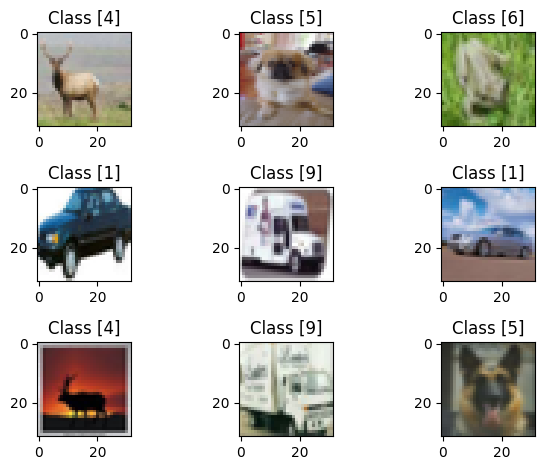

In [3]:
from dataset import load_and_preprocess, shuffle_data

dataset_configs = {
    'cifar10': {
        'data_name':'cifar10',
        'loader': keras.datasets.cifar10,
        'img_shape': (32, 32, 3),
        'is_color': True
    },
    'mnist': {
        'data_name':'mnist',
        'loader': keras.datasets.mnist,
        'img_shape': (28, 28, 1),
        'is_color': False
    },
    'fashion_mnist': {
        'data_name':'fashion_mnist',
        'loader': keras.datasets.fashion_mnist,
        'img_shape': (28, 28, 1),
        'is_color': False
    }
}

# Choose dataset
data_name = 'cifar10'                            # 'cifar10' / 'mnist' / 'fashion_mnist'
Nc = 10                                          # number of classes
N_in = 3072 if data_name == 'cifar10' else 784   # input units
val_split = 0.5
cfg = dataset_configs[data_name]

# Load dataset
x_train, y_train, x_val, y_val, x_test, y_test = load_and_preprocess(cfg['data_name'], cfg['loader'], cfg['img_shape'], Nc, val_split, cfg['is_color'])

## Single layer unsupervised training with E-I neurons
To reproduce the results of the paper, in the following blocks I will implement the input layer, a single hidden layer, and the output layer. I chose to focus specifically on varying the number of hidden layers in my experiments, as I find this to be the most intriguing parameter to explore. For the remaining parameter I choose to follow the training protocol of the paper, meaning:
- minibatches of size 100 (mnist and fashion mnist) and 1000 (cifar10)
- training for 1000 epochs
- learning rate decreased from 0.04 (mnist and fashion mnist) and 0.02 to 0 (cifar10) in the last epoch
- Lebesgue norm p is fixed to 2
- ranking parameter k is fixed to 2
- anti-Hebbian learning parameter Δ  is fixed to 0.1

To introduce EI dynamics I will modify the biological network code in two ways:
- we will assume e_prop = fraction of excitatory neurons
- initialize the synapses randomly with a negative value for the inhibitory neurons, with a positive one for excitatory neurons
- after each update we apply a mask to enforce the E-I separation.



In [ ]:
if data_name == 'cifar10':                          
    p = 2
    delta = 0.1
    k = 2
    prec = 0.1
    N_batch = 1000
    Nep  = 1000
    lr  = 2e-2
    
elif data_name == 'mnist' or data_name == 'fashion_mnist':                          
    p = 2
    delta = 0.1
    k = 2
    prec = 0.1
    N_batch = 100
    Nep  = 1000
    lr = 4e-2

fig=plt.figure(figsize=(10, 7))
def draw_weights(synapses, Kx, Ky, ax=None):
    # synapses: the weights
    Kw = int(np.sqrt(synapses.shape[1]//3)) # i.e. 32
    yy=0
    HM=np.zeros((Kw*Ky, Kw*Kx, 3))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*Kw:(y+1)*Kw,x*Kw:(x+1)*Kw]=synapses[yy,:Kw*Kw*3].reshape(Kw, Kw, 3)
            yy += 1

    nc=np.amax(np.absolute(HM))
    tmp = (HM-HM.min())
    tmp /= tmp.max()
    tmp *= 255
    tmp = tmp.astype(np.uint8)
    if ax is not None:
        im = ax.imshow(tmp)
        ax.axis('off')
    else:
        plt.clf()
        im=plt.imshow(tmp.astype(np.uint8))
        plt.axis('off')
    fig.canvas.draw()
    
def save_weight_frame(synapses, epoch, folder="EI_biolearning"):
    wlim = torch.max(torch.abs(synapses)).item()
    plt.figure(figsize=(6, 6))
    plt.imshow(synapses.cpu(), cmap='bwr_r', vmin=-wlim, vmax=wlim, aspect='auto')
    plt.title(f'Weights at epoch {epoch}')
    plt.xlabel('From neurons')
    plt.ylabel('To neurons')
    plt.colorbar()
    plt.tight_layout()
    filepath = os.path.join(folder, f"frame_{epoch:04d}.png")
    plt.savefig(filepath)
    plt.close()


def init_synapses(N_hid, N_in, e_prop=0.8, mu_ex=0.05, mu_in=-0.05, g=1.0, device='cuda'):
    """
    Initializes a synaptic weight matrix with excitatory/inhibitory neurons.

    Args:
        N_hid (int): Number of output neurons (i.e., neurons in the current layer)
        N_in (int): Number of input neurons (i.e., neurons in the previous layer)
        e_prop (float): Proportion of excitatory neurons (e.g., 0.8)
        mu_ex (float): Mean for excitatory weight initialization (> 0)
        mu_in (float): Mean for inhibitory weight initialization (< 0)
        g (float): Gain applied to the variance
        device (str): 'cpu' or 'cuda'

    Returns:
        torch.Tensor: Synaptic weight matrix of shape (N_hid x N_in)
    """
    e_size = int(e_prop * N_hid)
    i_size = N_hid - e_size
    sigma = np.sqrt(1 / N_in)

    # Excitaatory: positive weights
    W_E = g * np.random.normal(loc=mu_ex, scale=sigma, size=(e_size, N_in))
    W_E = np.clip(W_E, 0, None)  # Mantieni solo valori ≥ 0

    # Inhibitory: negative weights
    W_I = g * np.random.normal(loc=mu_in, scale=sigma, size=(i_size, N_in))
    W_I = np.clip(W_I, None, 0)  # Mantieni solo valori ≤ 0

    # Matrice finale
    W_total = np.vstack([W_E, W_I])
    W_tensor = torch.tensor(W_total, dtype=torch.float32).to(device)

    # Mask of signs: +1 for E, -1 for I
    sign_mask = torch.cat([torch.ones(e_size), -torch.ones(i_size)]).reshape(-1, 1).to(device)  # Shape (N_hid, 1)

    return W_tensor, sign_mask


def forward(inputs, synapses, p, k, N_hid, N_batch, delta, training=True):
     # Currents
    N_in = inputs.shape[1]
    inputs = torch.tensor(inputs, dtype=torch.float32, device=device).transpose(0, 1) # shape is (input_size, batch_size)
    sig = torch.sign(synapses).to(device)  # synapses are the W

    # with p=2, this is equal to <W.v> = I
    tot_input = torch.mm(sig*torch.abs(synapses).pow(p-1), inputs) # Shape is (output_size, batch_size)

    if training == False:
        return torch.transpose(tot_input, 0, 1)

    # Activations
    y = torch.argsort(tot_input, dim=0).to(device) # using tot_input (I) as proxy for h
    y1 = torch.zeros((N_hid, N_batch)).to(device)  # post activation currents: g(Q)
    y1[y[N_hid - 1, :], torch.arange(N_batch, device=device)] = 1.0
    y1[y[N_hid - k], torch.arange(N_batch, device=device)] = -delta

    # Compute change of weights
    xx = torch.sum(torch.mul(y1, tot_input), 1)    # g(Q) * <W, v>  --> Overlap between post_activation_currents and inputs
    ds = torch.matmul(y1, torch.transpose(inputs, 0, 1)) - torch.mul(xx.reshape(xx.shape[0],1).repeat(1, N_in), synapses) # delta weights
    nc = torch.max(torch.abs(ds))
    #ds.div_(nc + 1e-5)
    
    return ds, nc

def train_weights(x_train, N_hid, N_batch, Nep, delta, p, k, lr = 4e-2, device="cpu"):

    N_train, N_in = x_train.shape
    if isinstance(x_train, np.ndarray):
        x_train = torch.from_numpy(x_train).float().to(device)
    elif isinstance(x_train, torch.Tensor):
        x_train = x_train.float().to(device)
    else:
        raise TypeError("x_train deve essere un numpy.ndarray o un torch.Tensor")

    synapses, mask = init_synapses(N_hid, N_in)
    eps0 = torch.tensor(lr).to(device)

    for nep in tqdm(range(Nep)):
        eps=eps0*(1-nep/Nep)

        for i in range(N_train//N_batch):
            inputs=x_train[i*N_batch:(i+1)*N_batch,:] # v_i Shape is (batch_size, input_size)

            ds, nc = forward(inputs, synapses, p, k, N_hid, N_batch, delta)
            if nc < prec:
                nc = prec
            synapses += torch.mul(torch.div(ds, nc), eps)
            
            # Apply sign mask to enforce E/I constraint
            synapses = torch.abs(synapses) * mask
        
    return synapses


<Figure size 1000x700 with 0 Axes>

## E-I network with 1 hidden layer training 

  0%|          | 0/80 [00:00<?, ?it/s]

/tmp/ipykernel_24212/2878524147.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32, device=device).transpose(0, 1) # shape is (input_size, batch_size)
100%|██████████| 80/80 [00:05<00:00, 14.13it/s]


(280, 280)
Synapses list saved at: output_EI/mnist_single_100hu.pt


100%|██████████| 80/80 [00:05<00:00, 14.85it/s]


(140, 140)
Synapses list saved at: output_EI/mnist_single_50hu.pt


100%|██████████| 80/80 [00:05<00:00, 14.80it/s]


(84, 84)
Synapses list saved at: output_EI/mnist_single_10hu.pt


100%|██████████| 80/80 [00:05<00:00, 14.91it/s]


(56, 56)
Synapses list saved at: output_EI/mnist_single_5hu.pt


100%|██████████| 80/80 [00:05<00:00, 14.76it/s]


(28, 28)
Synapses list saved at: output_EI/mnist_single_2hu.pt


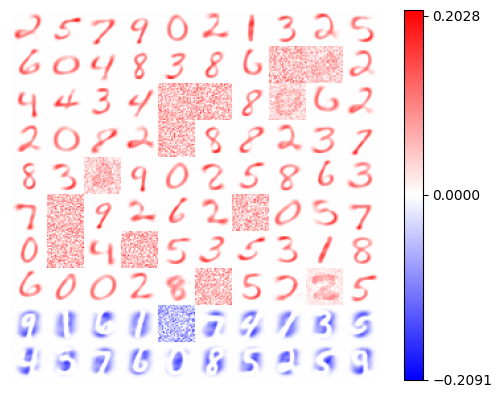

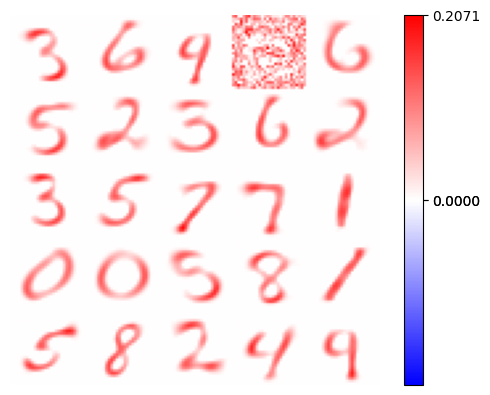

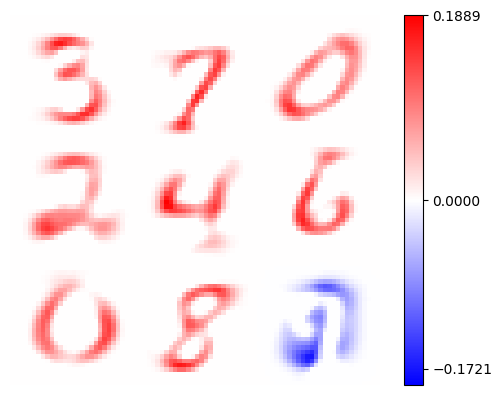

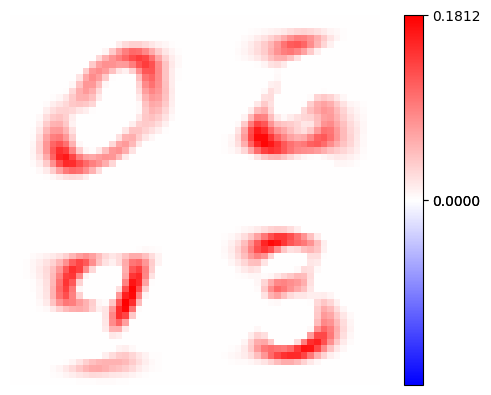

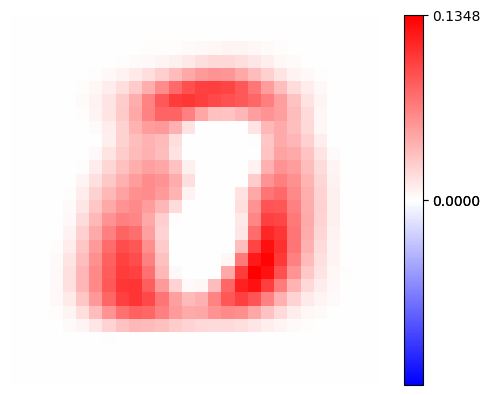

In [11]:
# mnist
def draw_weights(synapses, Kx, Ky,save_path):
    fig = plt.figure()
    yy=0
    HM=np.zeros((28*Ky,28*Kx))
    print(HM.shape)
    for y in range(Ky):
        for x in range(Kx):
            HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:28*28].reshape(28,28)
            yy += 1
    plt.clf()
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    plt.axis('off')
    plt.savefig(save_path)
    fig.canvas.draw()

N_hid_list =  [100,50, 10, 5, 2]
K_x_list = [10,5,3,2,1]
for i,N_hid in enumerate(N_hid_list):
    synapses = train_weights(x_train, N_hid=N_hid, N_batch=N_batch, Nep=80, delta=delta, p =p, k=k, lr = lr, device="cuda")
    save_path = f'output_EI/{data_name}_single_{N_hid}hu.png'
    draw_weights(synapses.cpu(), Kx = K_x_list[i], Ky = K_x_list[i], save_path=save_path)

    save_path = f'output_EI/{data_name}_single_{N_hid}hu.pt'
    torch.save(synapses, save_path)
    print(f"Synapses list saved at: {save_path}")

  0%|          | 0/80 [00:00<?, ?it/s]

/tmp/ipykernel_24212/2878524147.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32, device=device).transpose(0, 1) # shape is (input_size, batch_size)
100%|██████████| 80/80 [00:05<00:00, 14.45it/s]


(280, 280)
Synapses list saved at: output_EI/fashion_mnist_single_100hu.pt


100%|██████████| 80/80 [00:16<00:00,  4.90it/s]


(700, 700)
Synapses list saved at: output_EI/fashion_mnist_single_1000hu.pt


100%|██████████| 80/80 [00:05<00:00, 14.44it/s]


(140, 140)
Synapses list saved at: output_EI/fashion_mnist_single_50hu.pt


100%|██████████| 80/80 [00:05<00:00, 15.03it/s]


(84, 84)
Synapses list saved at: output_EI/fashion_mnist_single_10hu.pt


100%|██████████| 80/80 [00:05<00:00, 15.33it/s]


(56, 56)
Synapses list saved at: output_EI/fashion_mnist_single_5hu.pt


100%|██████████| 80/80 [00:05<00:00, 15.30it/s]


(28, 28)
Synapses list saved at: output_EI/fashion_mnist_single_2hu.pt


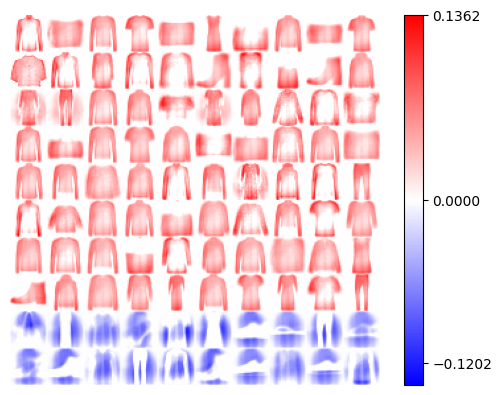

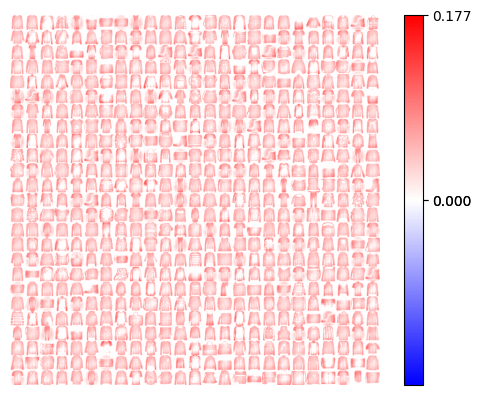

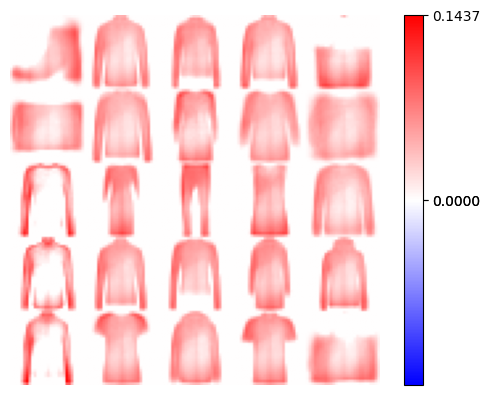

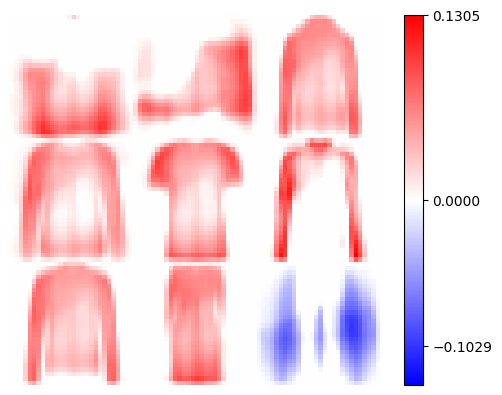

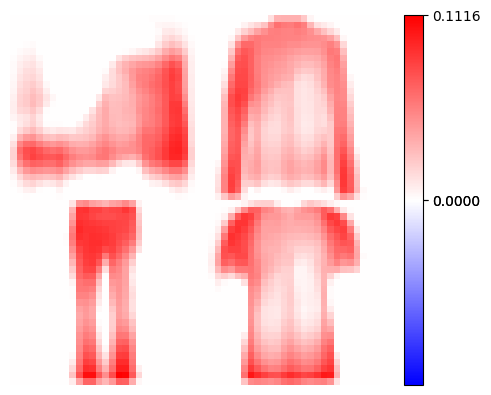

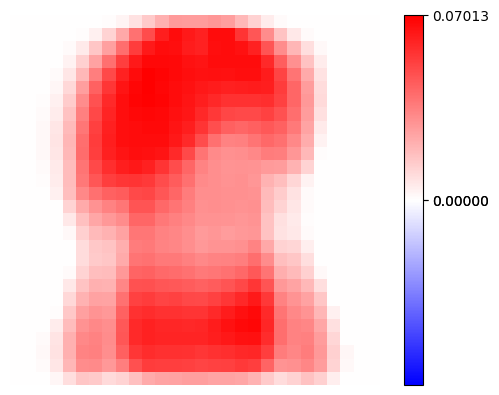

In [18]:
#fashion mnist
def draw_weights(synapses, Kx, Ky, save_path):
    fig = plt.figure()
    yy=0
    HM=np.zeros((28*Ky,28*Kx))
    print(HM.shape)
    for y in range(Ky):
        for x in range(Kx):
            HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:28*28].reshape(28,28)
            yy += 1
    plt.clf()
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    plt.axis('off')
    plt.savefig(save_path)
    fig.canvas.draw()

N_hid_list =  [100,1000,50, 10, 5, 2]
K_x_list = [10,25,5,3,2,1]

for i,N_hid in enumerate(N_hid_list):
    synapses = train_weights(x_train, N_hid=N_hid, N_batch=N_batch, Nep=80, delta=delta, p =p, k=k, lr = lr, device="cuda")
    save_path = f'output_EI/{data_name}_single_{N_hid}hu.png'
    draw_weights(synapses.cpu(), Kx = K_x_list[i], Ky = K_x_list[i], save_path=save_path)

    save_path = f'output_EI/{data_name}_single_{N_hid}hu.pt'
    torch.save(synapses, save_path)
    print(f"Synapses list saved at: {save_path}")

  0%|          | 0/80 [00:00<?, ?it/s]/tmp/ipykernel_24212/2878524147.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32, device=device).transpose(0, 1) # shape is (input_size, batch_size)
100%|██████████| 80/80 [00:19<00:00,  4.10it/s]


Synapses list saved at: output_EI/cifar10_single_2000hu.pt


100%|██████████| 80/80 [00:01<00:00, 51.26it/s]


Synapses list saved at: output_EI/cifar10_single_100hu.pt


100%|██████████| 80/80 [00:01<00:00, 64.39it/s]


Synapses list saved at: output_EI/cifar10_single_50hu.pt


100%|██████████| 80/80 [00:00<00:00, 104.59it/s]


Synapses list saved at: output_EI/cifar10_single_10hu.pt


100%|██████████| 80/80 [00:00<00:00, 117.58it/s]


Synapses list saved at: output_EI/cifar10_single_5hu.pt


100%|██████████| 80/80 [00:00<00:00, 131.46it/s]


Synapses list saved at: output_EI/cifar10_single_2hu.pt


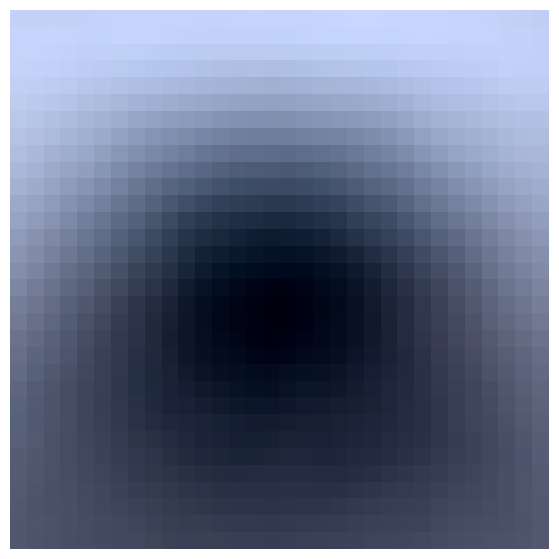

In [25]:
#cifar10
fig=plt.figure(figsize=(10, 7))
def draw_weights(synapses, Kx, Ky, save_path, ax=None):
    # synapses: the weights
    Kw = int(np.sqrt(synapses.shape[1]//3)) # i.e. 32
    yy=0
    HM=np.zeros((Kw*Ky, Kw*Kx, 3))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*Kw:(y+1)*Kw,x*Kw:(x+1)*Kw]=synapses[yy,:Kw*Kw*3].reshape(Kw, Kw, 3)
            yy += 1

    nc=np.amax(np.absolute(HM))
    tmp = (HM-HM.min())
    tmp /= tmp.max()
    tmp *= 255
    tmp = tmp.astype(np.uint8)
    if ax is not None:
        im = ax.imshow(tmp)
        ax.axis('off')
    else:
        plt.clf()
        im=plt.imshow(tmp.astype(np.uint8))
        plt.axis('off')
    plt.savefig(save_path)
    fig.canvas.draw()

N_hid_list = [2000, 100, 50, 10, 5, 2]
K_x_list = [40,10,5,3,2,1]


for i,N_hid in enumerate(N_hid_list):
    synapses = train_weights(x_train, N_hid=N_hid, N_batch=N_batch, Nep=80, delta=delta, p =p, k=k, lr = lr, device="cuda")
    save_path = f'output_EI/{data_name}_single_{N_hid}hu.png'
    draw_weights(synapses.cpu(), Kx = K_x_list[i], Ky = K_x_list[i], save_path=save_path)

    save_path = f'output_EI/{data_name}_single_{N_hid}hu.pt'
    torch.save(synapses, save_path)
    print(f"Synapses list saved at: {save_path}")

# Last layer supervised training

In [8]:
class BioClassifier(nn.Module):
    def __init__(self, synapses_list, out_features):
        super(BioClassifier, self).__init__()
        
        # Freeze all unsupervised weights by setting requires_grad=False
        self.synapses_list = []
        for i, W in enumerate(synapses_list):
            W = nn.Parameter(W.T, requires_grad=False)  # Transpose and freeze each layer's weights
            self.synapses_list.append(W)
        
        # Trainable supervised weights
        n_hidden = synapses_list[-1].size(0)  # The number of neurons in the last unsupervised layer
        self.S = nn.Linear(n_hidden, out_features)
        self.bn = nn.BatchNorm1d(out_features)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        # Forward through each unsupervised layer
        for W in self.synapses_list:
            x = torch.matmul(x, W) 
            x = torch.relu(x)  # Optional activation function

        # Forward through the supervised weights (last layer)
        x = self.S(x)
        x = self.bn(x)
        return self.softmax(x)



def train_bio_classifier(synapses_list, x_train, y_train,x_val, y_val, correct_img_bzs, data_name, layers_config, out_features, n_epochs, batch_size, anti_hebbian_learning_strength,
                       lebesgue_norm, rank, learning_rate,label, output_dir, dataset_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Clone initial unsupervised weights for verification
    initial_synapses = [W.clone().detach() for W in synapses_list]

    # Initialize BioClassifier with frozen W_unsupervised and multiple layers
    model = BioClassifier(synapses_list, out_features).to(device)

    # Define the loss function
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Scheduler setup
    scheduler = MultiStepLR(optimizer, milestones=[100, 150, 200, 250], gamma=0.5)

    # Lists for logging
    train_loss_log, val_loss_log, train_acc_log, val_acc_log = [], [], [], []

    # Training data
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    num_samples = x_train_tensor.shape[0]

    for epoch in range(n_epochs):
        model.train()
        total_loss, correct = 0, 0

        #for images, labels in train_loader:
        #    if images.shape[0] != correct_img_bzs:
        #        print(f"Batch scartato per dimensione errata: {images.shape}")
            #else:
                #print(f"Batch OK: {images.shape}")
        #        continue

        for i in range(0, num_samples, batch_size):
            images = x_train_tensor[i:i + batch_size]
            labels = y_train_tensor[i:i + batch_size]

            if images.shape[0] != correct_img_bzs:
                print(f"Batch scartato per dimensione errata: {images.shape}")
                continue
            # else:
            #     print(f"Batch OK: {images.shape}")

            images = images.view(batch_size, -1).to(device)  # Flatten images to (batch_size, img_sz)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

        # Calculate average loss and accuracy for the epoch
        train_loss = total_loss / len(x_train)
        train_accuracy = correct / len(x_train)

        # Store training logs
        train_loss_log.append(train_loss)
        train_acc_log.append(train_accuracy)

        # Validation every epochs
        val_loss, val_acc = validate(model, x_val, y_val, criterion, device, batch_size)
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)
        print(f"Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_acc:.4f}")

        # Scheduler step
        scheduler.step()

    # Verify unsupervised weights remain unchanged
    # Compare each tensor in the lists
    unchanged = True
    for synapse_tensor, initial_tensor in zip(synapses_list, initial_synapses):
        if not torch.equal(synapse_tensor, initial_tensor):
            unchanged = False
            break

    if unchanged:
        print("Unsupervised weights remained unchanged during supervised training.")
    else:
        print("Unsupervised weights have changed.")
        
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.plot(np.linspace(0, len(val_loss_log), len(val_loss_log)), train_loss_log, '.-', label='Train Loss', color='red', lw=2, alpha=0.5)
    plt.plot(np.linspace(0, len(val_loss_log), len(val_loss_log)), val_loss_log, '.-', label='Val Loss', color='blue', lw=2, alpha=0.5)
    plt.title(f'Training and Validation Loss for {layers_config} hidden units on {dataset_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'{output_dir}/{dataset_name}_{label}_{layers_config}hu_{out_features}out_{n_epochs}ep_ahls{anti_hebbian_learning_strength}_lnorm{lebesgue_norm}_rank{rank}_loss.png')
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    plt.plot(np.linspace(0, len(val_loss_log), len(val_loss_log)), train_acc_log, '.-', label='Train Accuracy', color='red', lw=2, alpha=0.5)
    plt.plot(np.linspace(0, len(val_loss_log), len(val_loss_log)), val_acc_log, '.-', label='Val Accuracy', color='blue', lw=2, alpha=0.5)
    plt.title(f'Training and Validation Accuracy for {layers_config} hidden units on {dataset_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f'{output_dir}/{dataset_name}_{label}_{layers_config}hu_{out_features}out_{n_epochs}ep_ahls{anti_hebbian_learning_strength}_lnorm{lebesgue_norm}_rank{rank}_acc.png')
    plt.show()

    return train_loss_log, val_loss_log, train_acc_log, val_acc_log


def validate(model,  x_val, y_val, criterion, device, batch_size):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    # Validation data
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)
    num_samples = x_val_tensor.shape[0]

    # Disable gradient calculations for validation
    with torch.no_grad():
        for i in range(0, num_samples, batch_size):
            images = x_val_tensor[i:i + batch_size]
            labels = y_val_tensor[i:i + batch_size]

            images = images.view(images.size(0), -1).to(device)  # Flatten images and move to device
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            #total += labels.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

    # Calculate average loss and accuracy
    avg_loss = total_loss / len(x_val)
    accuracy = correct / len(x_val)

    return avg_loss, accuracy

## Train of the last layer for single hidden layer

In [6]:
from utils import find_my_synapses

(60000, 28, 28)
x_train shape: (30000, 784)
y_train shape: (30000,)
x_val shape: (30000, 784)
y_val shape: (30000,)
30000 train samples
10000 test samples
Founded files:  {10: './output_EI/mnist_single_10hu.pt', 2: './output_EI/mnist_single_2hu.pt', 5: './output_EI/mnist_single_5hu.pt', 100: './output_EI/mnist_single_100hu.pt', 50: './output_EI/mnist_single_50hu.pt'}

[INFO] Inizio supervised training con 2 hidden units, file: ./output_EI/mnist_single_2hu.pt
Epoch [1/80], Train Loss: 2.2057, Val Loss: 2.1856, Train Acc: 0.2414, Val Acc: 0.2620
Epoch [2/80], Train Loss: 2.1673, Val Loss: 2.1698, Train Acc: 0.2763, Val Acc: 0.2757
Epoch [3/80], Train Loss: 2.1646, Val Loss: 2.1696, Train Acc: 0.2767, Val Acc: 0.2724
Epoch [4/80], Train Loss: 2.1633, Val Loss: 2.1679, Train Acc: 0.2772, Val Acc: 0.2674
Epoch [5/80], Train Loss: 2.1623, Val Loss: 2.1675, Train Acc: 0.2772, Val Acc: 0.2730
Epoch [6/80], Train Loss: 2.1617, Val Loss: 2.1691, Train Acc: 0.2772, Val Acc: 0.2704
Epoch [7/80], T

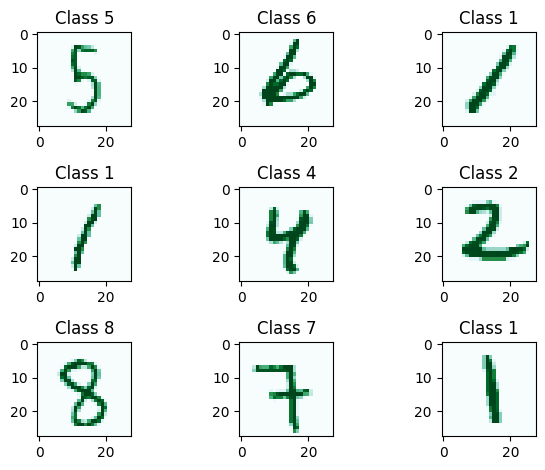

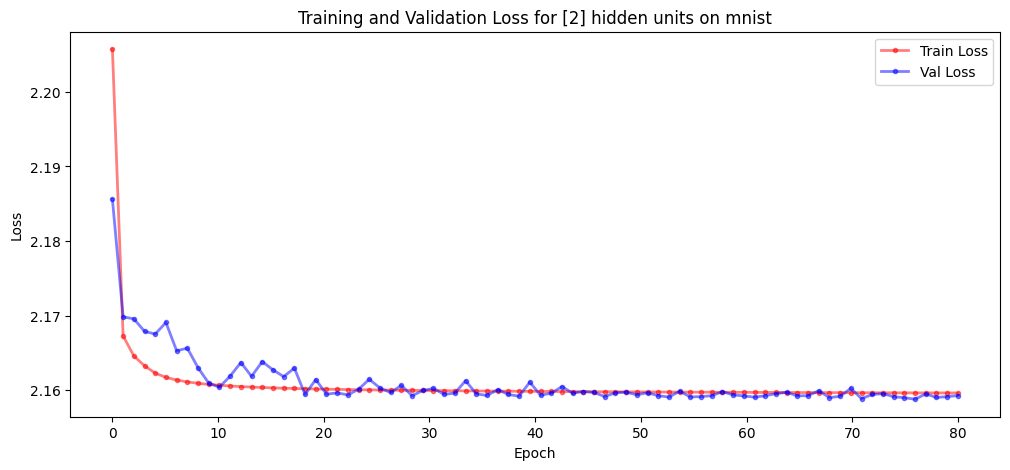

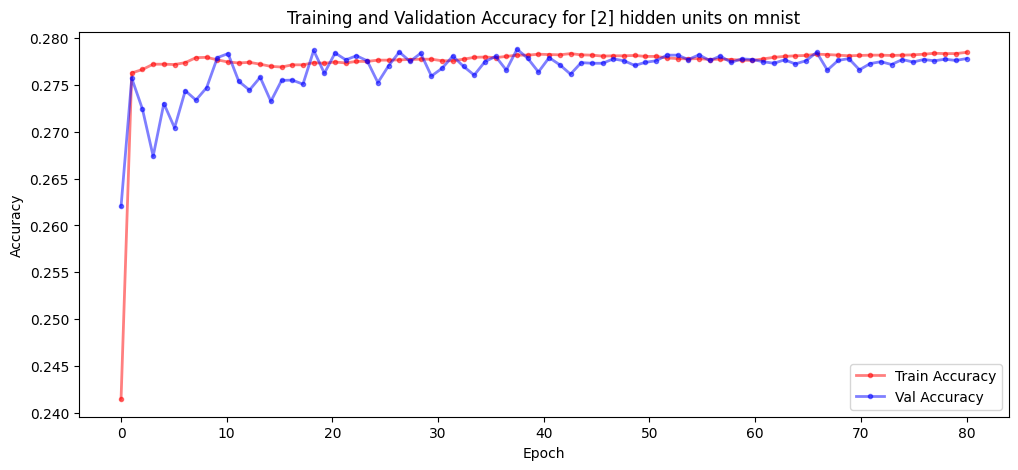


[INFO] Inizio supervised training con 5 hidden units, file: ./output_EI/mnist_single_5hu.pt
Epoch [1/80], Train Loss: 2.0791, Val Loss: 2.0404, Train Acc: 0.4025, Val Acc: 0.4409
Epoch [2/80], Train Loss: 2.0300, Val Loss: 2.0261, Train Acc: 0.4436, Val Acc: 0.4464
Epoch [3/80], Train Loss: 2.0206, Val Loss: 2.0196, Train Acc: 0.4498, Val Acc: 0.4490
Epoch [4/80], Train Loss: 2.0155, Val Loss: 2.0158, Train Acc: 0.4531, Val Acc: 0.4506
Epoch [5/80], Train Loss: 2.0124, Val Loss: 2.0137, Train Acc: 0.4544, Val Acc: 0.4503
Epoch [6/80], Train Loss: 2.0102, Val Loss: 2.0138, Train Acc: 0.4549, Val Acc: 0.4467
Epoch [7/80], Train Loss: 2.0085, Val Loss: 2.0118, Train Acc: 0.4553, Val Acc: 0.4488
Epoch [8/80], Train Loss: 2.0073, Val Loss: 2.0089, Train Acc: 0.4559, Val Acc: 0.4534
Epoch [9/80], Train Loss: 2.0062, Val Loss: 2.0086, Train Acc: 0.4560, Val Acc: 0.4514
Epoch [10/80], Train Loss: 2.0054, Val Loss: 2.0089, Train Acc: 0.4565, Val Acc: 0.4531
Epoch [11/80], Train Loss: 2.0046, V

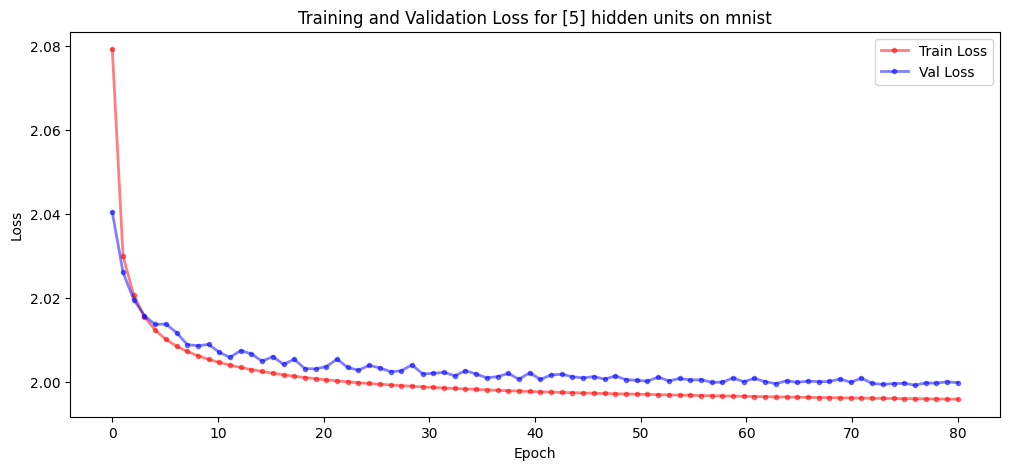

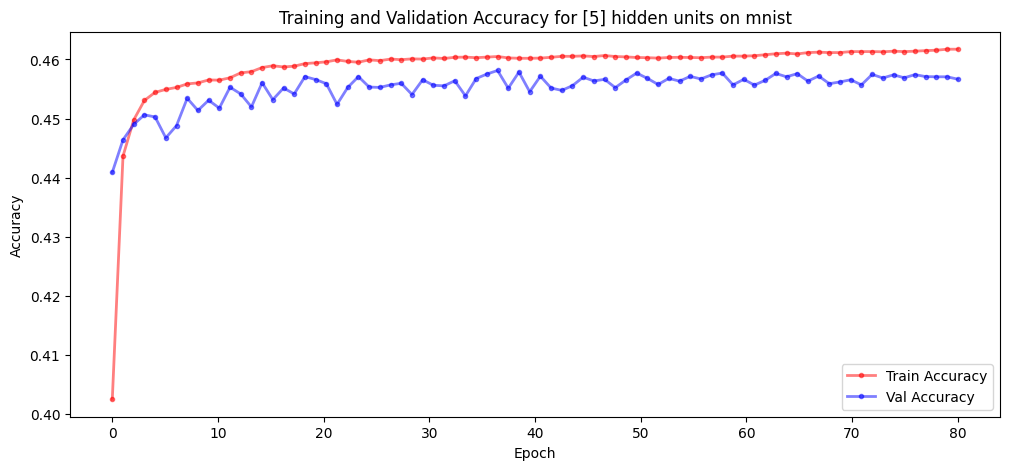


[INFO] Inizio supervised training con 10 hidden units, file: ./output_EI/mnist_single_10hu.pt
Epoch [1/80], Train Loss: 1.9002, Val Loss: 1.8335, Train Acc: 0.5934, Val Acc: 0.6521
Epoch [2/80], Train Loss: 1.8270, Val Loss: 1.8111, Train Acc: 0.6525, Val Acc: 0.6645
Epoch [3/80], Train Loss: 1.8140, Val Loss: 1.8031, Train Acc: 0.6615, Val Acc: 0.6747
Epoch [4/80], Train Loss: 1.8069, Val Loss: 1.7982, Train Acc: 0.6661, Val Acc: 0.6759
Epoch [5/80], Train Loss: 1.8023, Val Loss: 1.7974, Train Acc: 0.6692, Val Acc: 0.6741
Epoch [6/80], Train Loss: 1.7990, Val Loss: 1.7912, Train Acc: 0.6715, Val Acc: 0.6776
Epoch [7/80], Train Loss: 1.7965, Val Loss: 1.7876, Train Acc: 0.6728, Val Acc: 0.6815
Epoch [8/80], Train Loss: 1.7946, Val Loss: 1.7878, Train Acc: 0.6736, Val Acc: 0.6796
Epoch [9/80], Train Loss: 1.7929, Val Loss: 1.7855, Train Acc: 0.6746, Val Acc: 0.6811
Epoch [10/80], Train Loss: 1.7916, Val Loss: 1.7840, Train Acc: 0.6760, Val Acc: 0.6837
Epoch [11/80], Train Loss: 1.7904,

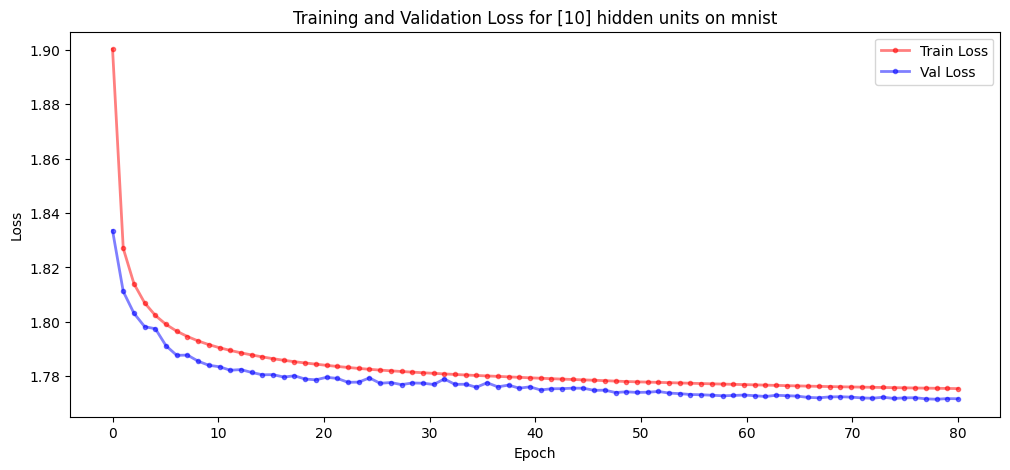

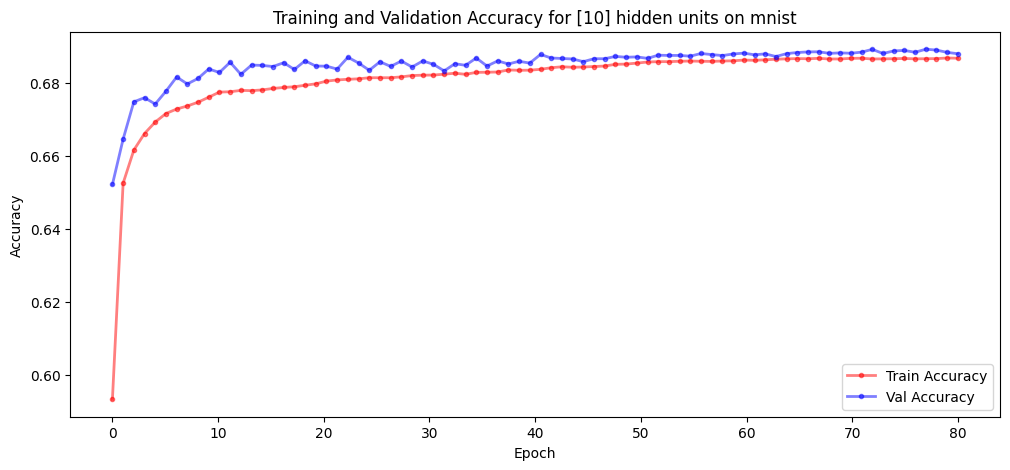


[INFO] Inizio supervised training con 50 hidden units, file: ./output_EI/mnist_single_50hu.pt
Epoch [1/80], Train Loss: 1.7180, Val Loss: 1.6416, Train Acc: 0.8045, Val Acc: 0.8509
Epoch [2/80], Train Loss: 1.6339, Val Loss: 1.6183, Train Acc: 0.8508, Val Acc: 0.8639
Epoch [3/80], Train Loss: 1.6197, Val Loss: 1.6079, Train Acc: 0.8592, Val Acc: 0.8702
Epoch [4/80], Train Loss: 1.6117, Val Loss: 1.6031, Train Acc: 0.8640, Val Acc: 0.8713
Epoch [5/80], Train Loss: 1.6067, Val Loss: 1.5990, Train Acc: 0.8674, Val Acc: 0.8736
Epoch [6/80], Train Loss: 1.6030, Val Loss: 1.5968, Train Acc: 0.8693, Val Acc: 0.8745
Epoch [7/80], Train Loss: 1.5999, Val Loss: 1.5968, Train Acc: 0.8716, Val Acc: 0.8737
Epoch [8/80], Train Loss: 1.5977, Val Loss: 1.5961, Train Acc: 0.8727, Val Acc: 0.8734
Epoch [9/80], Train Loss: 1.5962, Val Loss: 1.5933, Train Acc: 0.8737, Val Acc: 0.8751
Epoch [10/80], Train Loss: 1.5948, Val Loss: 1.5924, Train Acc: 0.8750, Val Acc: 0.8756
Epoch [11/80], Train Loss: 1.5934,

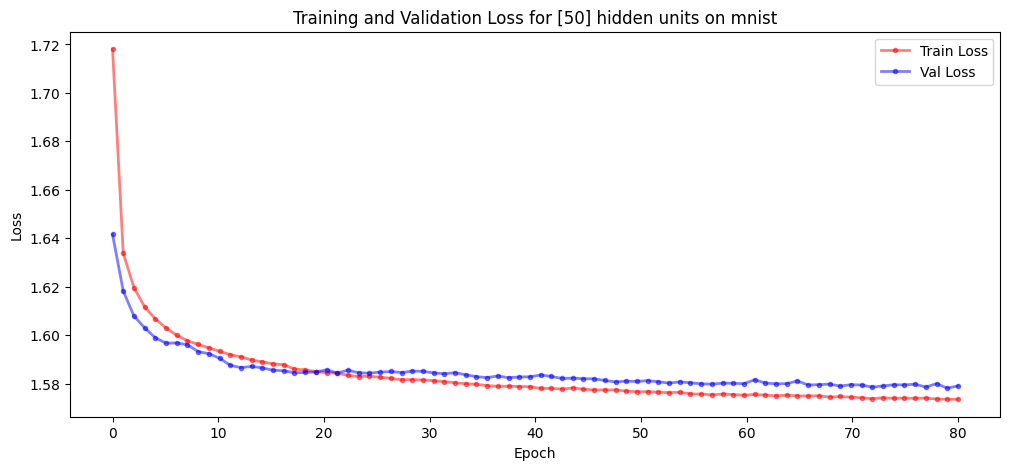

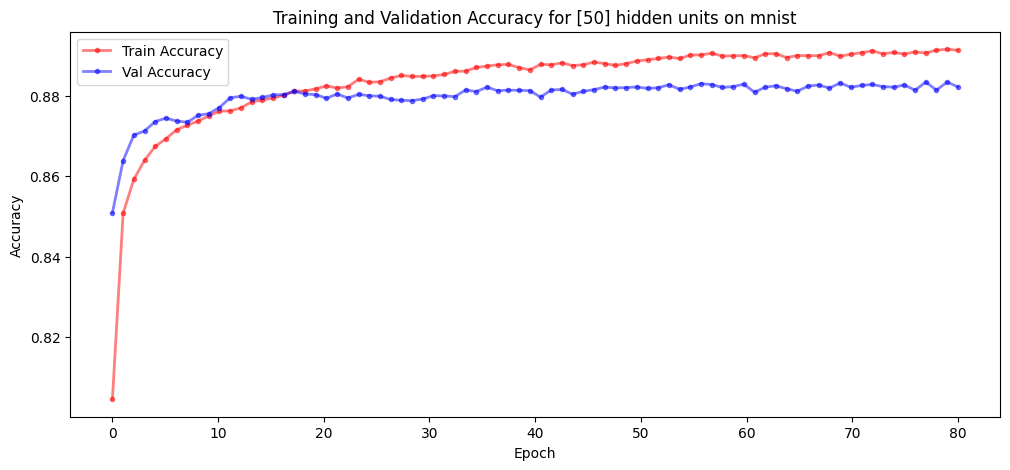


[INFO] Inizio supervised training con 100 hidden units, file: ./output_EI/mnist_single_100hu.pt
Epoch [1/80], Train Loss: 1.6962, Val Loss: 1.6159, Train Acc: 0.8300, Val Acc: 0.8760
Epoch [2/80], Train Loss: 1.6079, Val Loss: 1.5933, Train Acc: 0.8768, Val Acc: 0.8880
Epoch [3/80], Train Loss: 1.5948, Val Loss: 1.5869, Train Acc: 0.8821, Val Acc: 0.8906
Epoch [4/80], Train Loss: 1.5851, Val Loss: 1.5789, Train Acc: 0.8884, Val Acc: 0.8940
Epoch [5/80], Train Loss: 1.5794, Val Loss: 1.5729, Train Acc: 0.8927, Val Acc: 0.8982
Epoch [6/80], Train Loss: 1.5757, Val Loss: 1.5701, Train Acc: 0.8947, Val Acc: 0.9010
Epoch [7/80], Train Loss: 1.5723, Val Loss: 1.5713, Train Acc: 0.8973, Val Acc: 0.8983
Epoch [8/80], Train Loss: 1.5705, Val Loss: 1.5720, Train Acc: 0.8987, Val Acc: 0.8976
Epoch [9/80], Train Loss: 1.5696, Val Loss: 1.5661, Train Acc: 0.8993, Val Acc: 0.9024
Epoch [10/80], Train Loss: 1.5678, Val Loss: 1.5631, Train Acc: 0.9009, Val Acc: 0.9056
Epoch [11/80], Train Loss: 1.566

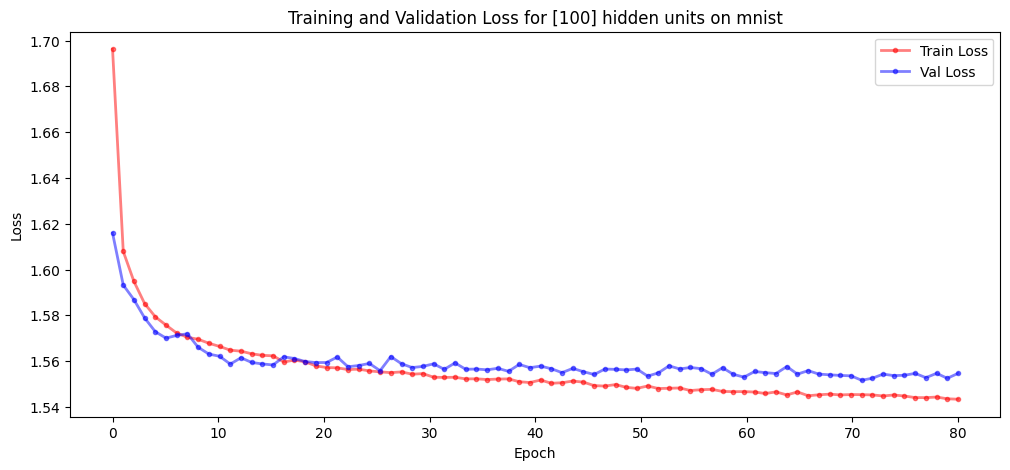

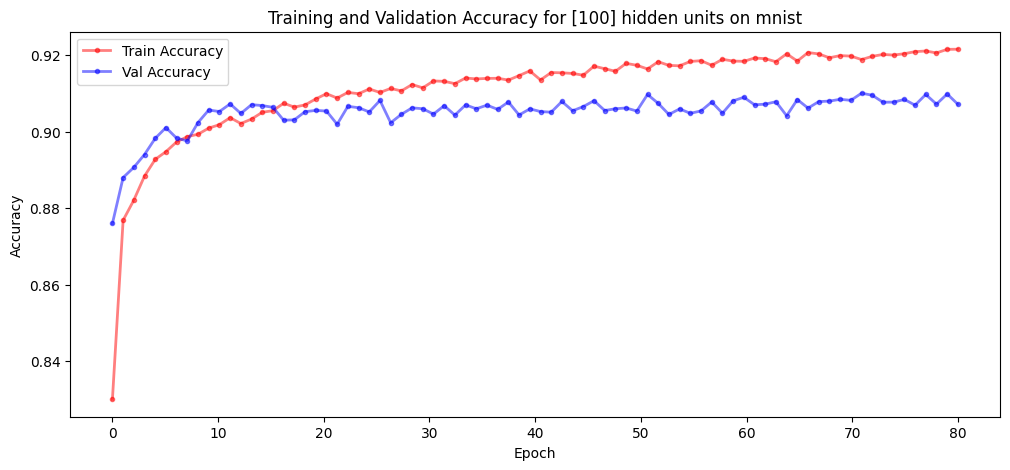

In [11]:
#### mnist dataset ####
data_name = 'mnist'
cfg = dataset_configs[data_name]
x_train, y_train, x_val, y_val, x_test, y_test = load_and_preprocess(cfg['data_name'], cfg['loader'], cfg['img_shape'], Nc, val_split, cfg['is_color'])

# parameters for unsupervised learning
p = 2
delta = 0.1
k = 2
prec = 0.1
N_batch = 1000
Nep  = 1000
lr  = 2e-2

# parameters for supervised learning
out_features = 10
n_epochs_supervised = 80
batch_size_supervised = 100
correct_img_bzs = 100
n_hidden = 10
learning_rate = 0.01

# Load synapses bio
hidden_units_files = find_my_synapses(source_directory = './output_EI', data_name = data_name)
print("Founded files: ", hidden_units_files)

#Logging
with open("./output_EI/mnist_acc_loss_training_data.txt", "w") as f:
    f.write("N_hidden\tVal_Acc\tTrain_Acc\tVal_loss\tTrain_loss\n")

# Train supervised last layer of size out_features x n_hid
for n_hidden in sorted(hidden_units_files.keys()):
    file_path = hidden_units_files[n_hidden]
    print(f"\n[INFO] Inizio supervised training con {n_hidden} hidden units, file: {file_path}")

    synapses = torch.load(file_path)
    synapses_list = [synapses]  

    train_loss_log, val_loss_log, train_acc_log, val_acc_log = train_bio_classifier(
        synapses_list=synapses_list,
        x_train = x_train,
        y_train = y_train,
        x_val = x_val, 
        y_val = y_val,
        correct_img_bzs=correct_img_bzs,
        data_name='mnist',
        layers_config=[n_hidden],  # aggiorna i layer con n_hidden corrente
        out_features=out_features,
        n_epochs=n_epochs_supervised,
        batch_size=batch_size_supervised,
        anti_hebbian_learning_strength=delta,
        lebesgue_norm=p,
        rank=k,
        learning_rate=lr,
        label=f'single-hidden-layer',
        output_dir='output_EI', 
        dataset_name = data_name
    )

    with open("./output_EI/mnist_acc_loss_training_data.txt", "a") as f:
        f.write(f"{n_hidden}\t{np.mean(val_acc_log[-10:]):.4f}\t{np.mean(train_acc_log[-10:]):.4f}\t{np.mean(val_loss_log[-10:]):.4f}\t{np.mean(train_loss_log[-10:]):.4f}\n")


(60000, 28, 28)
x_train shape: (30000, 784)
y_train shape: (30000,)
x_val shape: (30000, 784)
y_val shape: (30000,)
30000 train samples
10000 test samples

[INFO] Inizio supervised training con 2 hidden units, file: ./output_EI/fashion_mnist_single_2hu.pt
Epoch [1/80], Train Loss: 2.2071, Val Loss: 2.1873, Train Acc: 0.2440, Val Acc: 0.2460
Epoch [2/80], Train Loss: 2.1787, Val Loss: 2.1802, Train Acc: 0.2677, Val Acc: 0.2638
Epoch [3/80], Train Loss: 2.1679, Val Loss: 2.1711, Train Acc: 0.2799, Val Acc: 0.2720
Epoch [4/80], Train Loss: 2.1637, Val Loss: 2.1661, Train Acc: 0.2872, Val Acc: 0.2837
Epoch [5/80], Train Loss: 2.1617, Val Loss: 2.1647, Train Acc: 0.2891, Val Acc: 0.2823
Epoch [6/80], Train Loss: 2.1604, Val Loss: 2.1624, Train Acc: 0.2898, Val Acc: 0.2857
Epoch [7/80], Train Loss: 2.1593, Val Loss: 2.1609, Train Acc: 0.2897, Val Acc: 0.2852
Epoch [8/80], Train Loss: 2.1586, Val Loss: 2.1614, Train Acc: 0.2907, Val Acc: 0.2847
Epoch [9/80], Train Loss: 2.1579, Val Loss: 2.16

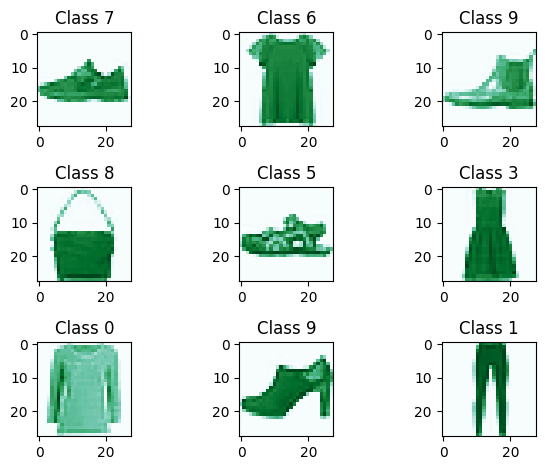

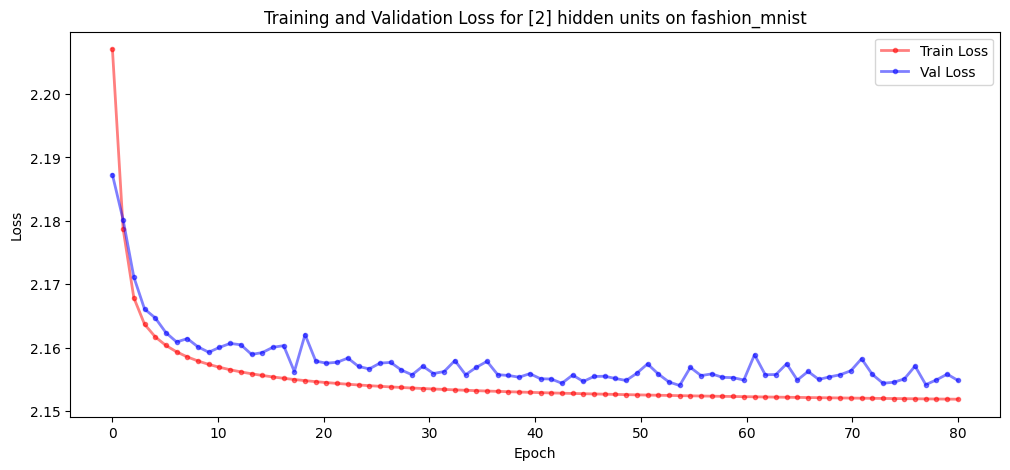

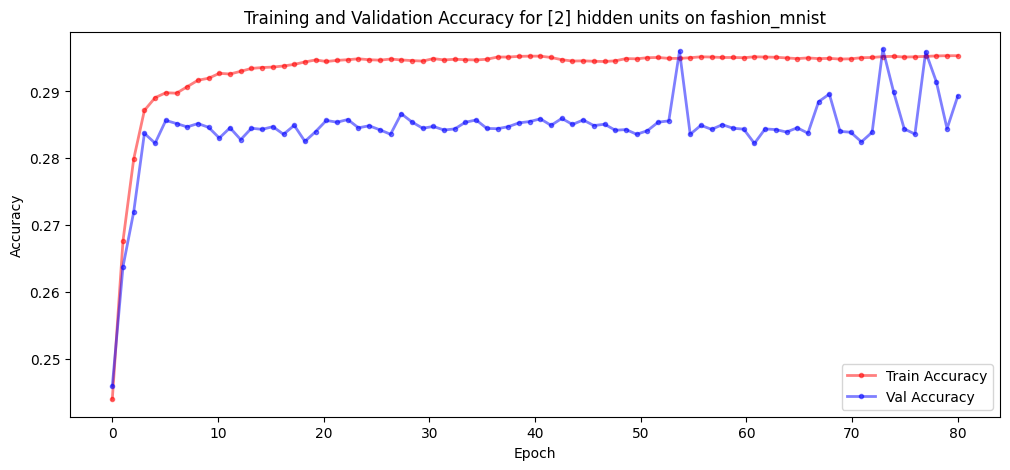


[INFO] Inizio supervised training con 5 hidden units, file: ./output_EI/fashion_mnist_single_5hu.pt
Epoch [1/80], Train Loss: 2.0155, Val Loss: 1.9429, Train Acc: 0.4810, Val Acc: 0.5410
Epoch [2/80], Train Loss: 1.9390, Val Loss: 1.9303, Train Acc: 0.5385, Val Acc: 0.5423
Epoch [3/80], Train Loss: 1.9269, Val Loss: 1.9138, Train Acc: 0.5476, Val Acc: 0.5565
Epoch [4/80], Train Loss: 1.9206, Val Loss: 1.9100, Train Acc: 0.5513, Val Acc: 0.5646
Epoch [5/80], Train Loss: 1.9165, Val Loss: 1.9078, Train Acc: 0.5542, Val Acc: 0.5606
Epoch [6/80], Train Loss: 1.9135, Val Loss: 1.9029, Train Acc: 0.5555, Val Acc: 0.5694
Epoch [7/80], Train Loss: 1.9113, Val Loss: 1.9007, Train Acc: 0.5570, Val Acc: 0.5664
Epoch [8/80], Train Loss: 1.9095, Val Loss: 1.8991, Train Acc: 0.5581, Val Acc: 0.5696
Epoch [9/80], Train Loss: 1.9081, Val Loss: 1.8969, Train Acc: 0.5585, Val Acc: 0.5712
Epoch [10/80], Train Loss: 1.9069, Val Loss: 1.8972, Train Acc: 0.5589, Val Acc: 0.5684
Epoch [11/80], Train Loss: 1

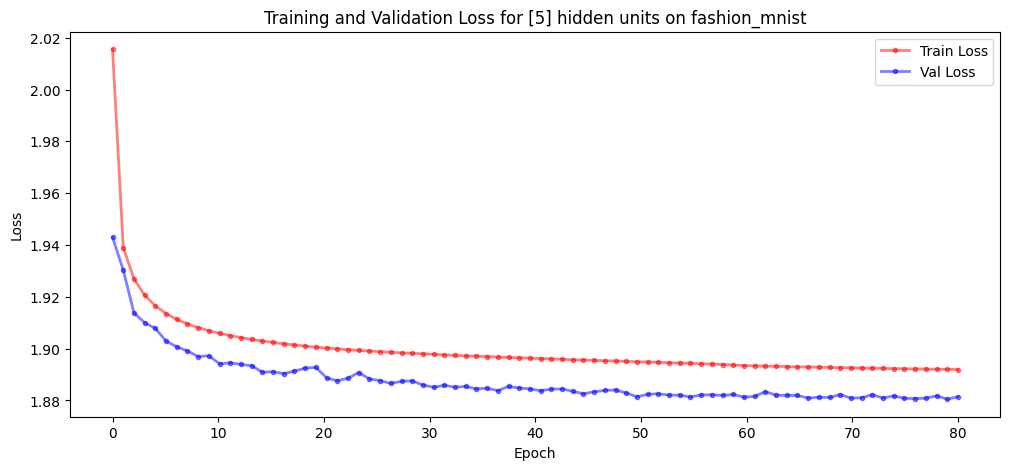

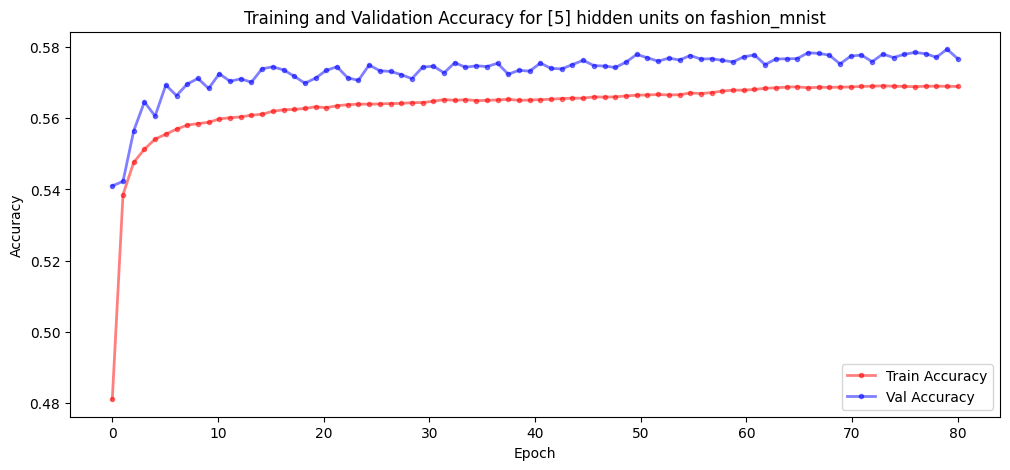


[INFO] Inizio supervised training con 10 hidden units, file: ./output_EI/fashion_mnist_single_10hu.pt
Epoch [1/80], Train Loss: 1.9608, Val Loss: 1.8997, Train Acc: 0.5261, Val Acc: 0.5721
Epoch [2/80], Train Loss: 1.8897, Val Loss: 1.8781, Train Acc: 0.5810, Val Acc: 0.5888
Epoch [3/80], Train Loss: 1.8804, Val Loss: 1.8679, Train Acc: 0.5882, Val Acc: 0.6002
Epoch [4/80], Train Loss: 1.8744, Val Loss: 1.8595, Train Acc: 0.5937, Val Acc: 0.6083
Epoch [5/80], Train Loss: 1.8688, Val Loss: 1.8588, Train Acc: 0.5993, Val Acc: 0.6073
Epoch [6/80], Train Loss: 1.8648, Val Loss: 1.8553, Train Acc: 0.6030, Val Acc: 0.6093
Epoch [7/80], Train Loss: 1.8614, Val Loss: 1.8491, Train Acc: 0.6057, Val Acc: 0.6185
Epoch [8/80], Train Loss: 1.8587, Val Loss: 1.8457, Train Acc: 0.6084, Val Acc: 0.6214
Epoch [9/80], Train Loss: 1.8565, Val Loss: 1.8439, Train Acc: 0.6105, Val Acc: 0.6226
Epoch [10/80], Train Loss: 1.8546, Val Loss: 1.8454, Train Acc: 0.6121, Val Acc: 0.6204
Epoch [11/80], Train Loss:

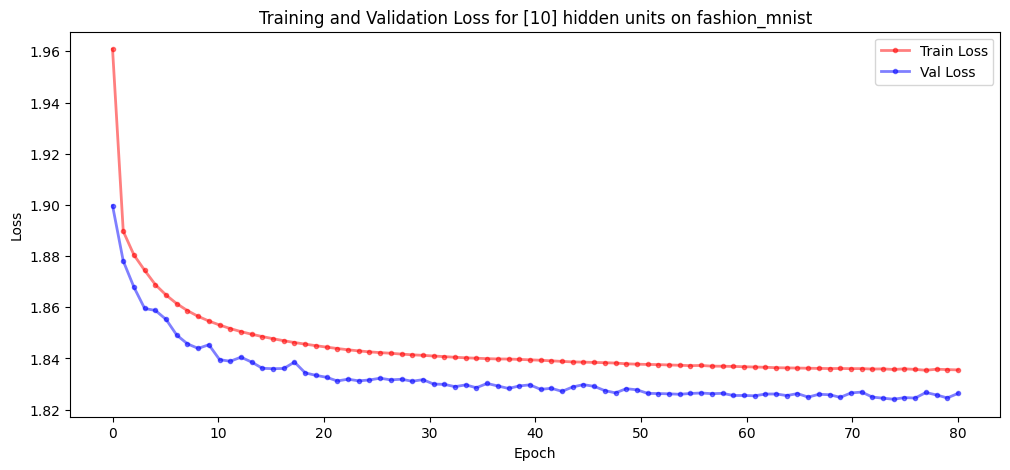

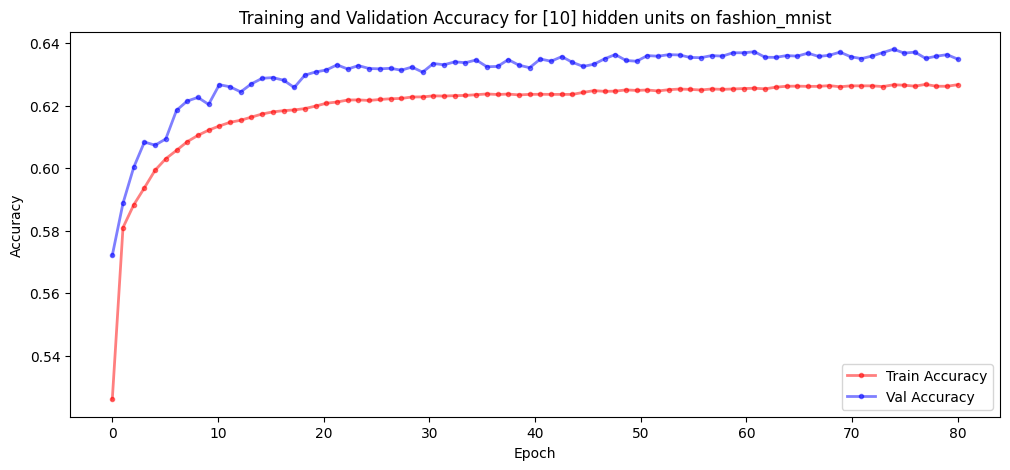


[INFO] Inizio supervised training con 50 hidden units, file: ./output_EI/fashion_mnist_single_50hu.pt
Epoch [1/80], Train Loss: 1.8359, Val Loss: 1.8005, Train Acc: 0.6649, Val Acc: 0.6727
Epoch [2/80], Train Loss: 1.7628, Val Loss: 1.7568, Train Acc: 0.7125, Val Acc: 0.7146
Epoch [3/80], Train Loss: 1.7502, Val Loss: 1.7432, Train Acc: 0.7202, Val Acc: 0.7252
Epoch [4/80], Train Loss: 1.7441, Val Loss: 1.7314, Train Acc: 0.7250, Val Acc: 0.7388
Epoch [5/80], Train Loss: 1.7382, Val Loss: 1.7253, Train Acc: 0.7301, Val Acc: 0.7425
Epoch [6/80], Train Loss: 1.7353, Val Loss: 1.7158, Train Acc: 0.7326, Val Acc: 0.7512
Epoch [7/80], Train Loss: 1.7321, Val Loss: 1.7253, Train Acc: 0.7347, Val Acc: 0.7417
Epoch [8/80], Train Loss: 1.7307, Val Loss: 1.7133, Train Acc: 0.7367, Val Acc: 0.7522
Epoch [9/80], Train Loss: 1.7258, Val Loss: 1.7128, Train Acc: 0.7396, Val Acc: 0.7542
Epoch [10/80], Train Loss: 1.7193, Val Loss: 1.7099, Train Acc: 0.7464, Val Acc: 0.7548
Epoch [11/80], Train Loss:

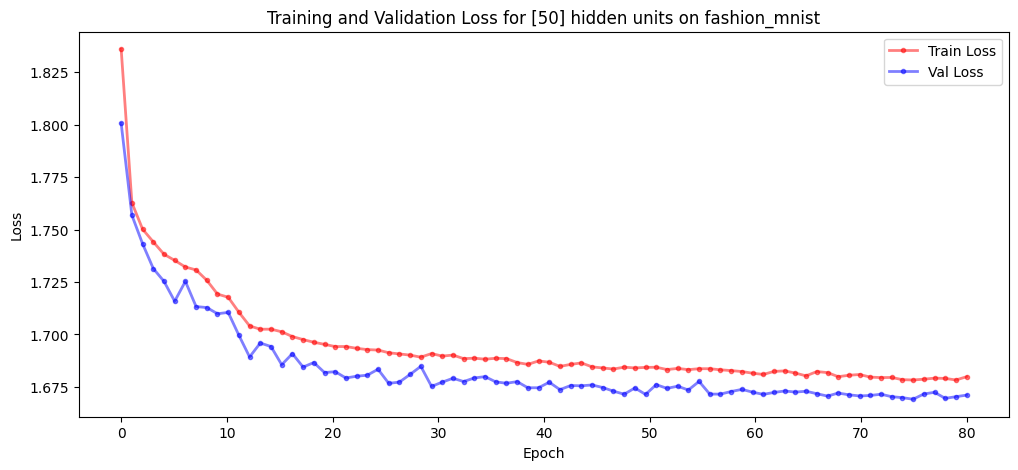

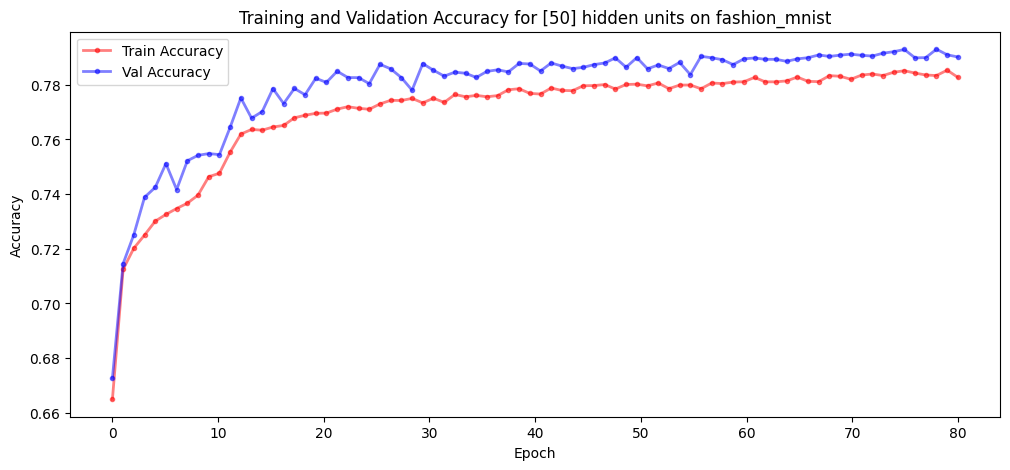


[INFO] Inizio supervised training con 100 hidden units, file: ./output_EI/fashion_mnist_single_100hu.pt
Epoch [1/80], Train Loss: 1.8219, Val Loss: 1.7926, Train Acc: 0.6835, Val Acc: 0.6839
Epoch [2/80], Train Loss: 1.7487, Val Loss: 1.7576, Train Acc: 0.7270, Val Acc: 0.7173
Epoch [3/80], Train Loss: 1.7277, Val Loss: 1.7439, Train Acc: 0.7442, Val Acc: 0.7236
Epoch [4/80], Train Loss: 1.7195, Val Loss: 1.7002, Train Acc: 0.7519, Val Acc: 0.7687
Epoch [5/80], Train Loss: 1.7109, Val Loss: 1.7052, Train Acc: 0.7587, Val Acc: 0.7630
Epoch [6/80], Train Loss: 1.7057, Val Loss: 1.6868, Train Acc: 0.7628, Val Acc: 0.7810
Epoch [7/80], Train Loss: 1.7055, Val Loss: 1.6900, Train Acc: 0.7632, Val Acc: 0.7787
Epoch [8/80], Train Loss: 1.7021, Val Loss: 1.7052, Train Acc: 0.7652, Val Acc: 0.7634
Epoch [9/80], Train Loss: 1.6990, Val Loss: 1.6969, Train Acc: 0.7695, Val Acc: 0.7710
Epoch [10/80], Train Loss: 1.6968, Val Loss: 1.7046, Train Acc: 0.7709, Val Acc: 0.7594
Epoch [11/80], Train Los

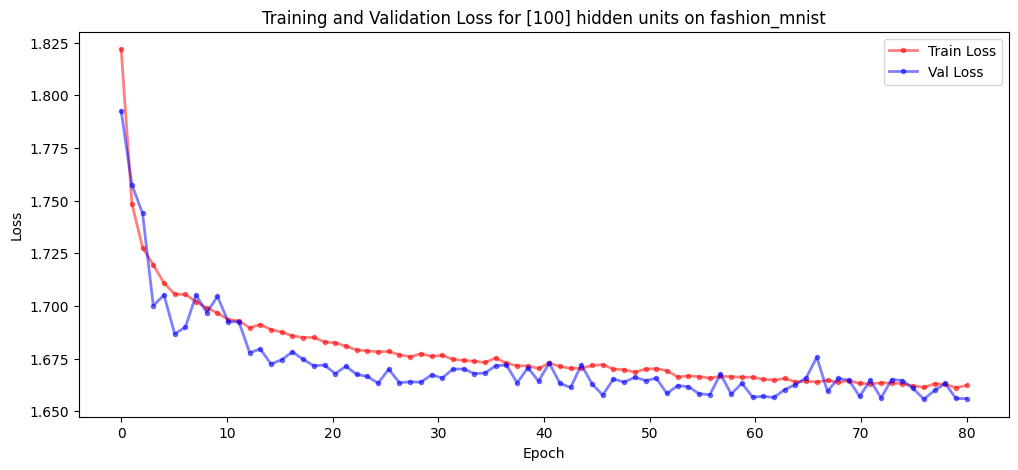

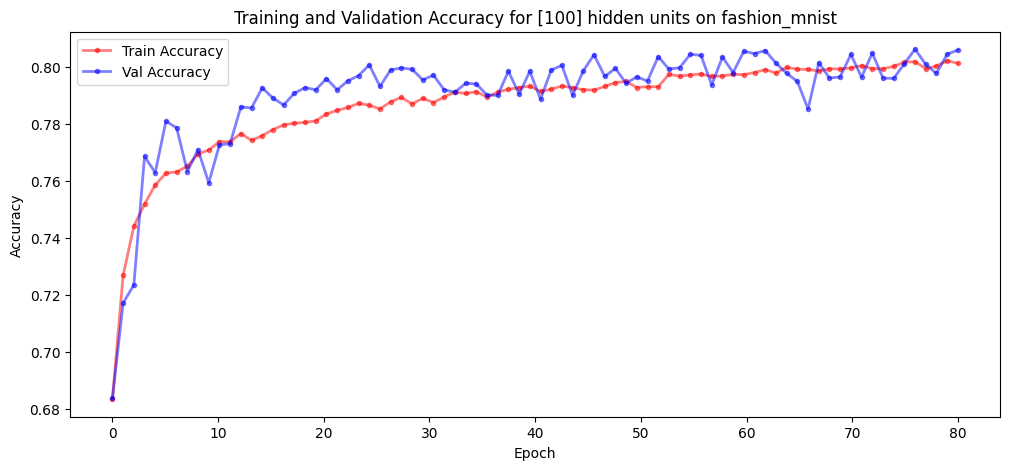


[INFO] Inizio supervised training con 1000 hidden units, file: ./output_EI/fashion_mnist_single_1000hu.pt
Epoch [1/80], Train Loss: 1.9139, Val Loss: 1.7874, Train Acc: 0.5819, Val Acc: 0.6977
Epoch [2/80], Train Loss: 1.7736, Val Loss: 1.7806, Train Acc: 0.7036, Val Acc: 0.6908
Epoch [3/80], Train Loss: 1.7559, Val Loss: 1.7845, Train Acc: 0.7177, Val Acc: 0.6796
Epoch [4/80], Train Loss: 1.7447, Val Loss: 1.7616, Train Acc: 0.7249, Val Acc: 0.7052
Epoch [5/80], Train Loss: 1.7397, Val Loss: 1.7509, Train Acc: 0.7296, Val Acc: 0.7165
Epoch [6/80], Train Loss: 1.7320, Val Loss: 1.7134, Train Acc: 0.7370, Val Acc: 0.7552
Epoch [7/80], Train Loss: 1.7263, Val Loss: 1.7204, Train Acc: 0.7399, Val Acc: 0.7454
Epoch [8/80], Train Loss: 1.7236, Val Loss: 1.7280, Train Acc: 0.7433, Val Acc: 0.7377
Epoch [9/80], Train Loss: 1.7209, Val Loss: 1.7163, Train Acc: 0.7449, Val Acc: 0.7502
Epoch [10/80], Train Loss: 1.7185, Val Loss: 1.7097, Train Acc: 0.7485, Val Acc: 0.7594
Epoch [11/80], Train L

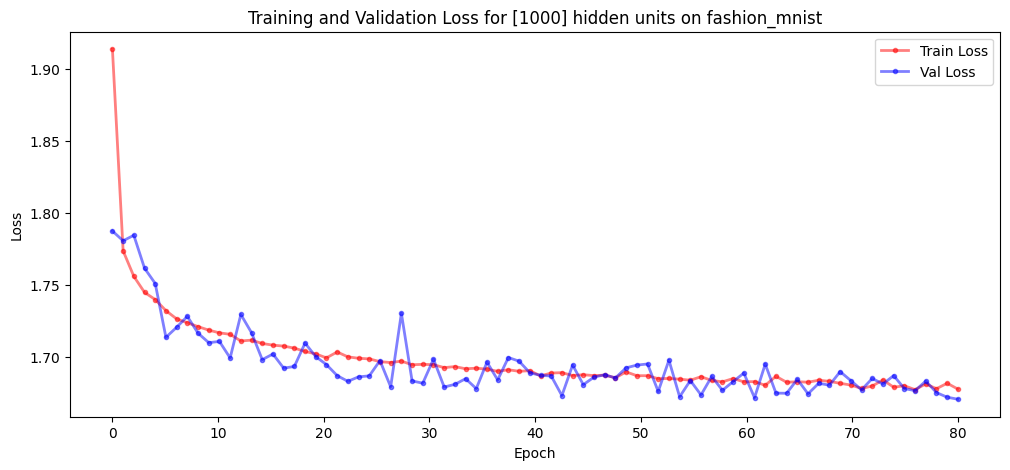

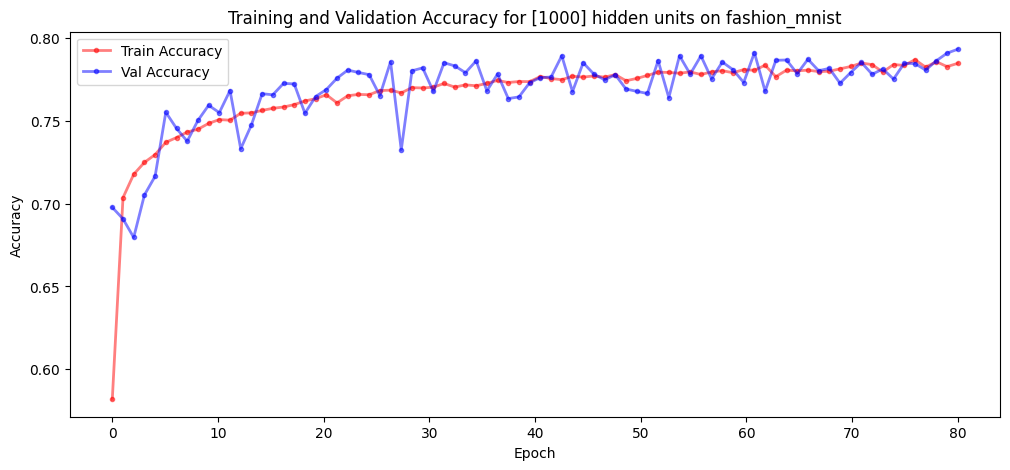

In [12]:

#### fashion mnist dataset ####
data_name = 'fashion_mnist'
cfg = dataset_configs[data_name]
x_train, y_train, x_val, y_val, x_test, y_test = load_and_preprocess(cfg['data_name'], cfg['loader'], cfg['img_shape'], Nc, val_split, cfg['is_color'])

p = 2
delta = 0.1
k = 2
prec = 0.1
N_batch = 1000
Nep  = 1000
lr  = 2e-2

# parameters for supervised learning
out_features = 10
n_epochs_supervised = 80
batch_size_supervised = 100
correct_img_bzs = 100
n_hidden = 10
learning_rate = 0.01

#Logging
with open("./output_EI/fashion_mnist_acc_loss_training_data.txt", "w") as f:
    f.write("N_hidden\tVal_Acc\tTrain_Acc\tVal_loss\tTrain_loss\n")

# Load synapses bio
hidden_units_files = find_my_synapses(source_directory = './output_EI', data_name = data_name)

# Train supervised last layer of size out_features x n_hid
for n_hidden in sorted(hidden_units_files.keys()):
    file_path = hidden_units_files[n_hidden]
    print(f"\n[INFO] Inizio supervised training con {n_hidden} hidden units, file: {file_path}")

    synapses = torch.load(file_path)
    synapses_list = [synapses]  

    train_loss_log, val_loss_log, train_acc_log, val_acc_log = train_bio_classifier(
        synapses_list=synapses_list,
        x_train = x_train,
        y_train = y_train,
        x_val = x_val, 
        y_val = y_val,
        correct_img_bzs=correct_img_bzs,
        data_name='fashion_mnist',
        layers_config=[n_hidden],  # aggiorna i layer con n_hidden corrente
        out_features=out_features,
        n_epochs=n_epochs_supervised,
        batch_size=batch_size_supervised,
        anti_hebbian_learning_strength=delta,
        lebesgue_norm=p,
        rank=k,
        learning_rate=lr,
        label=f'single-hidden-layer',
        output_dir='output_EI', 
        dataset_name = data_name
    )

    with open("./output_EI/fashion_mnist_acc_loss_training_data.txt", "a") as f:
        f.write(f"{n_hidden}\t{np.mean(val_acc_log[-10:]):.4f}\t{np.mean(train_acc_log[-10:]):.4f}\t{np.mean(val_loss_log[-10:]):.4f}\t{np.mean(train_loss_log[-10:]):.4f}\n")


(50000, 32, 32, 3)
x_train shape: (25000, 3072)
y_train shape: (25000, 1)
x_val shape: (25000, 3072)
y_val shape: (25000, 1)
25000 train samples
10000 test samples

[INFO] Inizio supervised training con 2 hidden units, file: ./output_EI/cifar10_single_2hu.pt
Epoch [1/80], Train Loss: 2.2706, Val Loss: 2.2569, Train Acc: 0.1603, Val Acc: 0.1758
Epoch [2/80], Train Loss: 2.2584, Val Loss: 2.2553, Train Acc: 0.1734, Val Acc: 0.1783
Epoch [3/80], Train Loss: 2.2578, Val Loss: 2.2551, Train Acc: 0.1730, Val Acc: 0.1762
Epoch [4/80], Train Loss: 2.2575, Val Loss: 2.2549, Train Acc: 0.1728, Val Acc: 0.1777
Epoch [5/80], Train Loss: 2.2574, Val Loss: 2.2553, Train Acc: 0.1726, Val Acc: 0.1754
Epoch [6/80], Train Loss: 2.2573, Val Loss: 2.2551, Train Acc: 0.1728, Val Acc: 0.1768
Epoch [7/80], Train Loss: 2.2572, Val Loss: 2.2547, Train Acc: 0.1725, Val Acc: 0.1772
Epoch [8/80], Train Loss: 2.2572, Val Loss: 2.2548, Train Acc: 0.1726, Val Acc: 0.1768
Epoch [9/80], Train Loss: 2.2571, Val Loss: 2

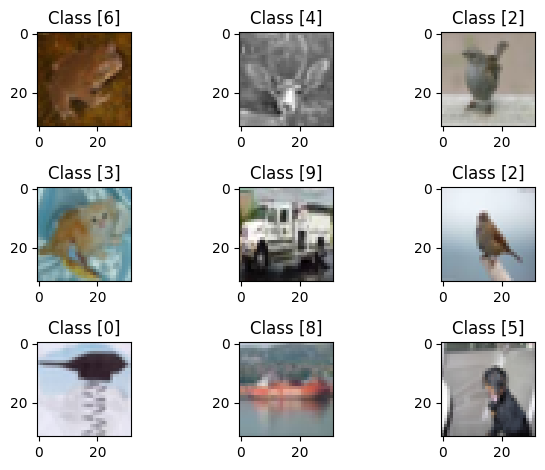

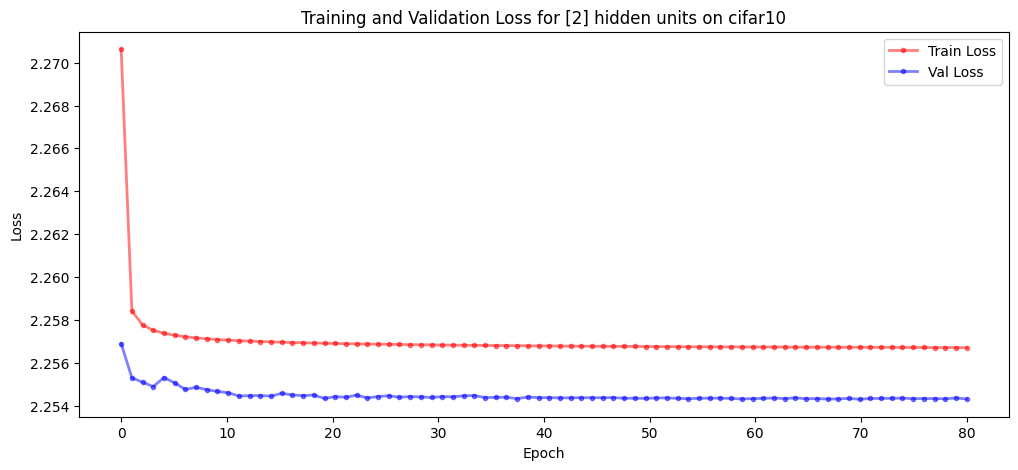

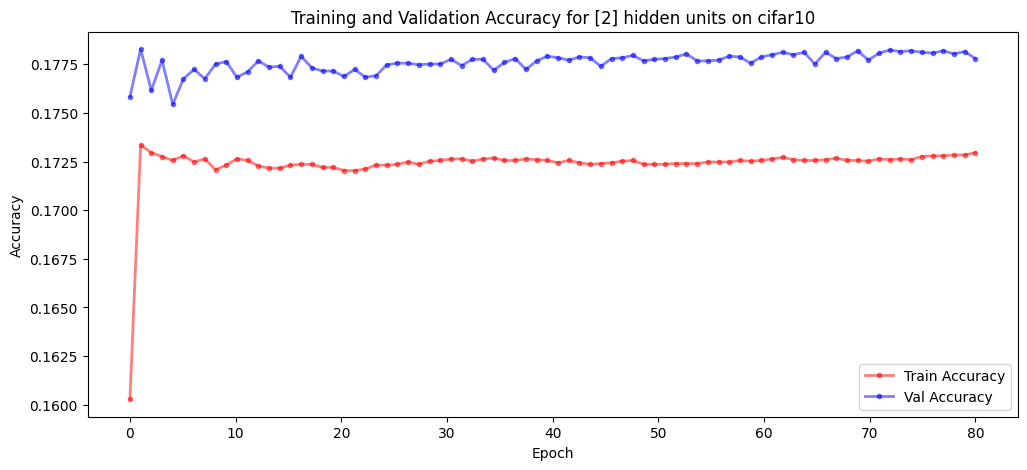


[INFO] Inizio supervised training con 5 hidden units, file: ./output_EI/cifar10_single_5hu.pt
Epoch [1/80], Train Loss: 2.2257, Val Loss: 2.2105, Train Acc: 0.2192, Val Acc: 0.2370
Epoch [2/80], Train Loss: 2.2113, Val Loss: 2.2082, Train Acc: 0.2348, Val Acc: 0.2378
Epoch [3/80], Train Loss: 2.2098, Val Loss: 2.2078, Train Acc: 0.2347, Val Acc: 0.2376
Epoch [4/80], Train Loss: 2.2084, Val Loss: 2.2059, Train Acc: 0.2356, Val Acc: 0.2395
Epoch [5/80], Train Loss: 2.2071, Val Loss: 2.2053, Train Acc: 0.2373, Val Acc: 0.2401
Epoch [6/80], Train Loss: 2.2066, Val Loss: 2.2046, Train Acc: 0.2377, Val Acc: 0.2413
Epoch [7/80], Train Loss: 2.2062, Val Loss: 2.2038, Train Acc: 0.2384, Val Acc: 0.2425
Epoch [8/80], Train Loss: 2.2059, Val Loss: 2.2033, Train Acc: 0.2384, Val Acc: 0.2433
Epoch [9/80], Train Loss: 2.2057, Val Loss: 2.2030, Train Acc: 0.2388, Val Acc: 0.2444
Epoch [10/80], Train Loss: 2.2055, Val Loss: 2.2031, Train Acc: 0.2392, Val Acc: 0.2432
Epoch [11/80], Train Loss: 2.2054,

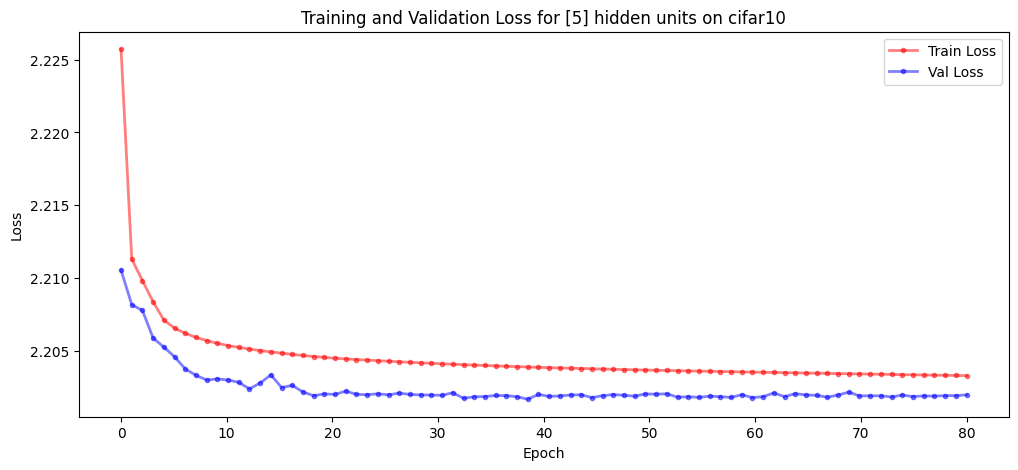

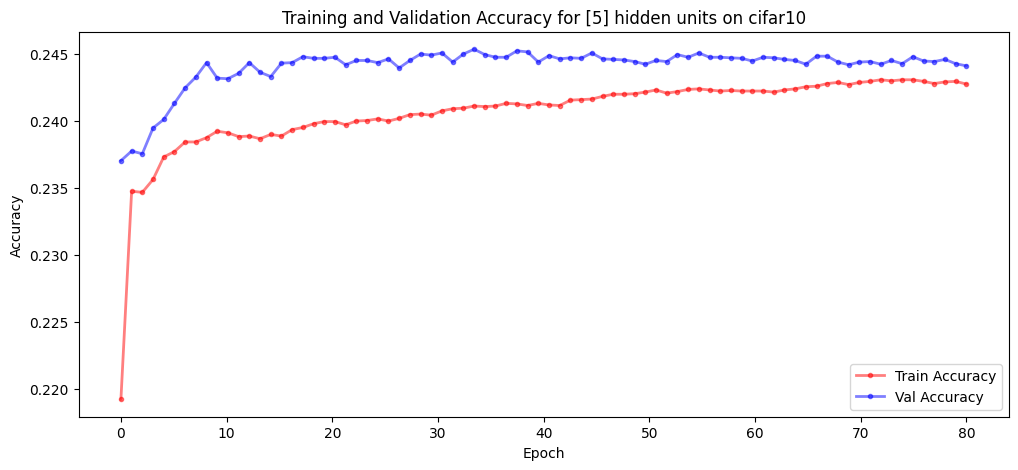


[INFO] Inizio supervised training con 10 hidden units, file: ./output_EI/cifar10_single_10hu.pt
Epoch [1/80], Train Loss: 2.1970, Val Loss: 2.1799, Train Acc: 0.2547, Val Acc: 0.2724
Epoch [2/80], Train Loss: 2.1772, Val Loss: 2.1737, Train Acc: 0.2736, Val Acc: 0.2789
Epoch [3/80], Train Loss: 2.1731, Val Loss: 2.1709, Train Acc: 0.2781, Val Acc: 0.2810
Epoch [4/80], Train Loss: 2.1713, Val Loss: 2.1692, Train Acc: 0.2807, Val Acc: 0.2820
Epoch [5/80], Train Loss: 2.1699, Val Loss: 2.1677, Train Acc: 0.2818, Val Acc: 0.2831
Epoch [6/80], Train Loss: 2.1690, Val Loss: 2.1675, Train Acc: 0.2831, Val Acc: 0.2837
Epoch [7/80], Train Loss: 2.1684, Val Loss: 2.1673, Train Acc: 0.2831, Val Acc: 0.2838
Epoch [8/80], Train Loss: 2.1679, Val Loss: 2.1666, Train Acc: 0.2836, Val Acc: 0.2843
Epoch [9/80], Train Loss: 2.1675, Val Loss: 2.1666, Train Acc: 0.2838, Val Acc: 0.2842
Epoch [10/80], Train Loss: 2.1673, Val Loss: 2.1661, Train Acc: 0.2845, Val Acc: 0.2849
Epoch [11/80], Train Loss: 2.167

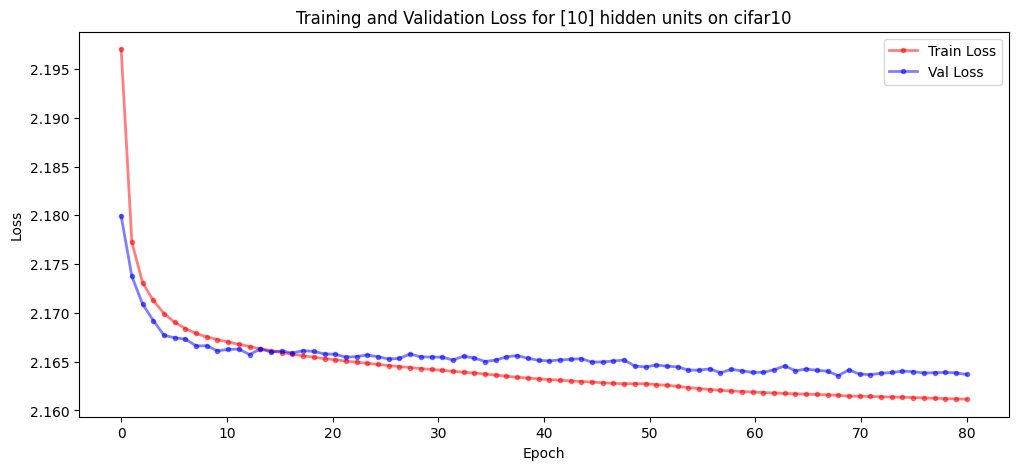

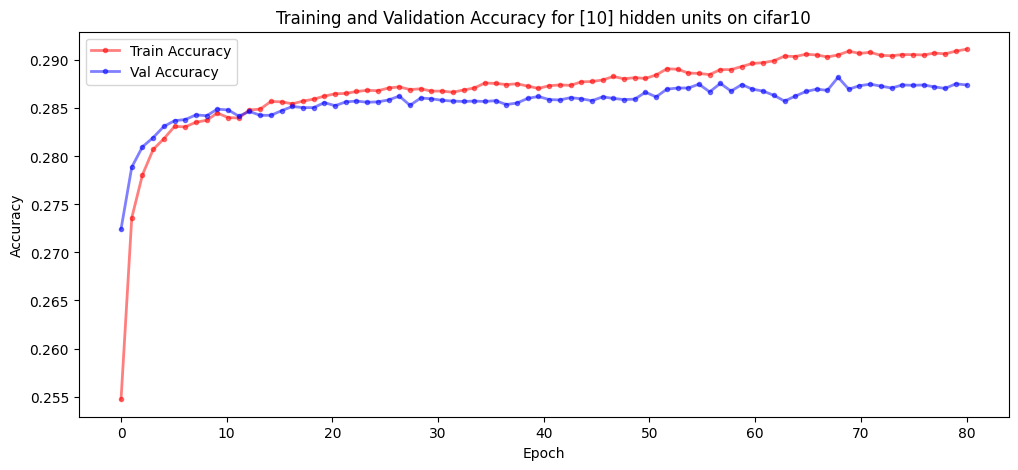


[INFO] Inizio supervised training con 50 hidden units, file: ./output_EI/cifar10_single_50hu.pt
Epoch [1/80], Train Loss: 2.1831, Val Loss: 2.1569, Train Acc: 0.2746, Val Acc: 0.2967
Epoch [2/80], Train Loss: 2.1492, Val Loss: 2.1432, Train Acc: 0.3077, Val Acc: 0.3110
Epoch [3/80], Train Loss: 2.1393, Val Loss: 2.1338, Train Acc: 0.3156, Val Acc: 0.3214
Epoch [4/80], Train Loss: 2.1317, Val Loss: 2.1330, Train Acc: 0.3243, Val Acc: 0.3205
Epoch [5/80], Train Loss: 2.1292, Val Loss: 2.1372, Train Acc: 0.3264, Val Acc: 0.3181
Epoch [6/80], Train Loss: 2.1268, Val Loss: 2.1259, Train Acc: 0.3291, Val Acc: 0.3290
Epoch [7/80], Train Loss: 2.1229, Val Loss: 2.1215, Train Acc: 0.3331, Val Acc: 0.3336
Epoch [8/80], Train Loss: 2.1208, Val Loss: 2.1236, Train Acc: 0.3355, Val Acc: 0.3313
Epoch [9/80], Train Loss: 2.1206, Val Loss: 2.1217, Train Acc: 0.3357, Val Acc: 0.3339
Epoch [10/80], Train Loss: 2.1186, Val Loss: 2.1180, Train Acc: 0.3357, Val Acc: 0.3367
Epoch [11/80], Train Loss: 2.118

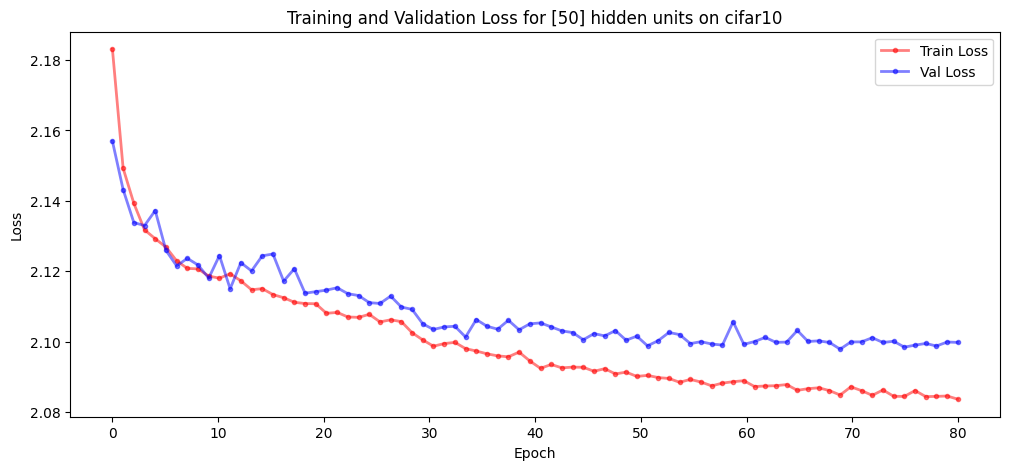

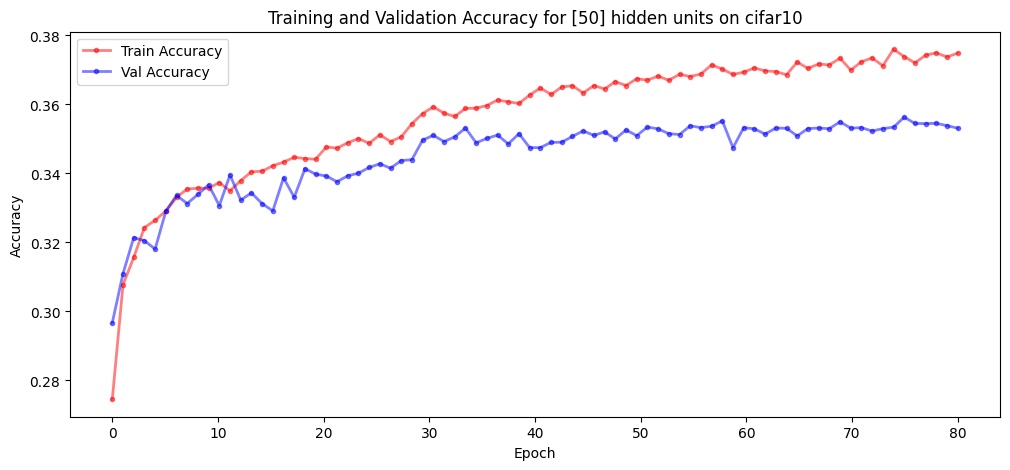


[INFO] Inizio supervised training con 100 hidden units, file: ./output_EI/cifar10_single_100hu.pt
Epoch [1/80], Train Loss: 2.1968, Val Loss: 2.1647, Train Acc: 0.2584, Val Acc: 0.2922
Epoch [2/80], Train Loss: 2.1617, Val Loss: 2.1546, Train Acc: 0.2925, Val Acc: 0.2993
Epoch [3/80], Train Loss: 2.1519, Val Loss: 2.1536, Train Acc: 0.3027, Val Acc: 0.3014
Epoch [4/80], Train Loss: 2.1477, Val Loss: 2.1526, Train Acc: 0.3071, Val Acc: 0.2983
Epoch [5/80], Train Loss: 2.1449, Val Loss: 2.1497, Train Acc: 0.3097, Val Acc: 0.3028
Epoch [6/80], Train Loss: 2.1404, Val Loss: 2.1418, Train Acc: 0.3143, Val Acc: 0.3122
Epoch [7/80], Train Loss: 2.1373, Val Loss: 2.1404, Train Acc: 0.3189, Val Acc: 0.3126
Epoch [8/80], Train Loss: 2.1366, Val Loss: 2.1504, Train Acc: 0.3185, Val Acc: 0.3020
Epoch [9/80], Train Loss: 2.1323, Val Loss: 2.1375, Train Acc: 0.3240, Val Acc: 0.3174
Epoch [10/80], Train Loss: 2.1297, Val Loss: 2.1366, Train Acc: 0.3270, Val Acc: 0.3166
Epoch [11/80], Train Loss: 2.1

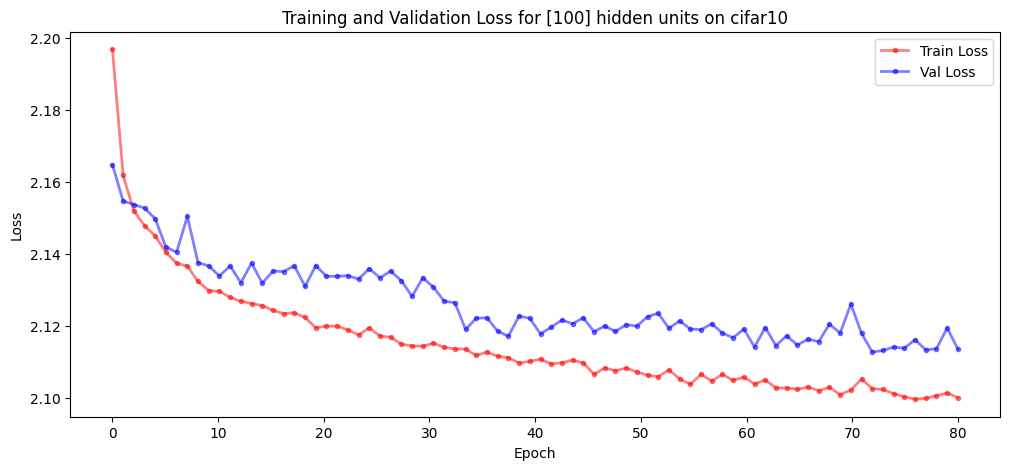

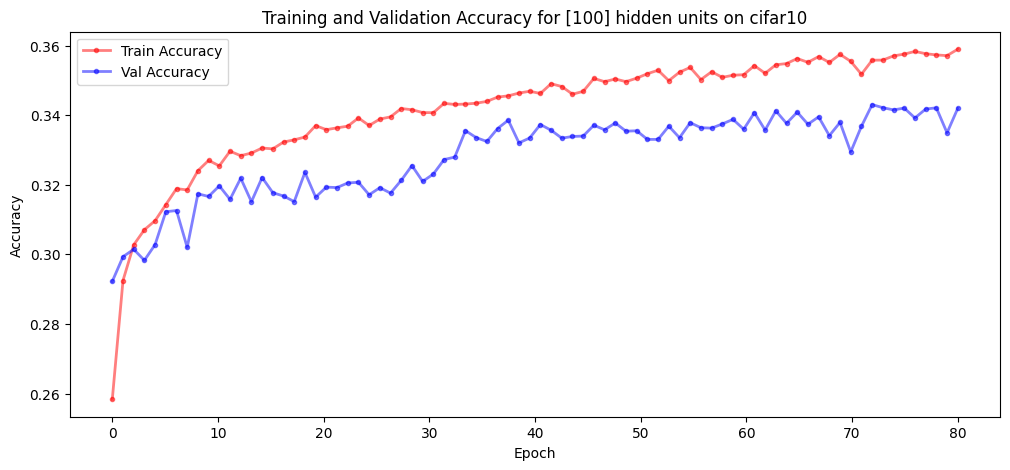


[INFO] Inizio supervised training con 2000 hidden units, file: ./output_EI/cifar10_single_2000hu.pt
Epoch [1/80], Train Loss: 2.2246, Val Loss: 2.1854, Train Acc: 0.2242, Val Acc: 0.2663
Epoch [2/80], Train Loss: 2.1748, Val Loss: 2.1598, Train Acc: 0.2779, Val Acc: 0.2961
Epoch [3/80], Train Loss: 2.1552, Val Loss: 2.1479, Train Acc: 0.2970, Val Acc: 0.3060
Epoch [4/80], Train Loss: 2.1376, Val Loss: 2.1239, Train Acc: 0.3176, Val Acc: 0.3300
Epoch [5/80], Train Loss: 2.1284, Val Loss: 2.1318, Train Acc: 0.3284, Val Acc: 0.3212
Epoch [6/80], Train Loss: 2.1244, Val Loss: 2.1244, Train Acc: 0.3318, Val Acc: 0.3312
Epoch [7/80], Train Loss: 2.1186, Val Loss: 2.1162, Train Acc: 0.3382, Val Acc: 0.3359
Epoch [8/80], Train Loss: 2.1164, Val Loss: 2.1118, Train Acc: 0.3407, Val Acc: 0.3431
Epoch [9/80], Train Loss: 2.1134, Val Loss: 2.1281, Train Acc: 0.3434, Val Acc: 0.3244
Epoch [10/80], Train Loss: 2.1113, Val Loss: 2.1159, Train Acc: 0.3470, Val Acc: 0.3384
Epoch [11/80], Train Loss: 2

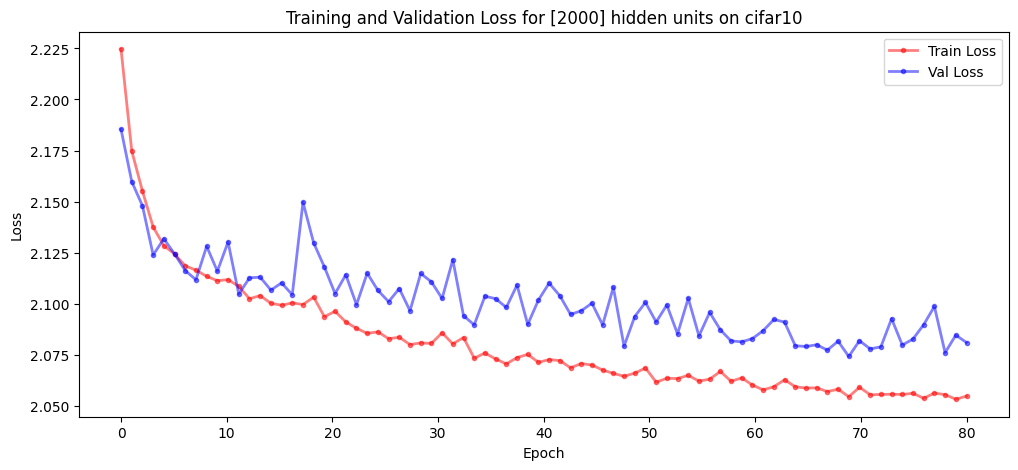

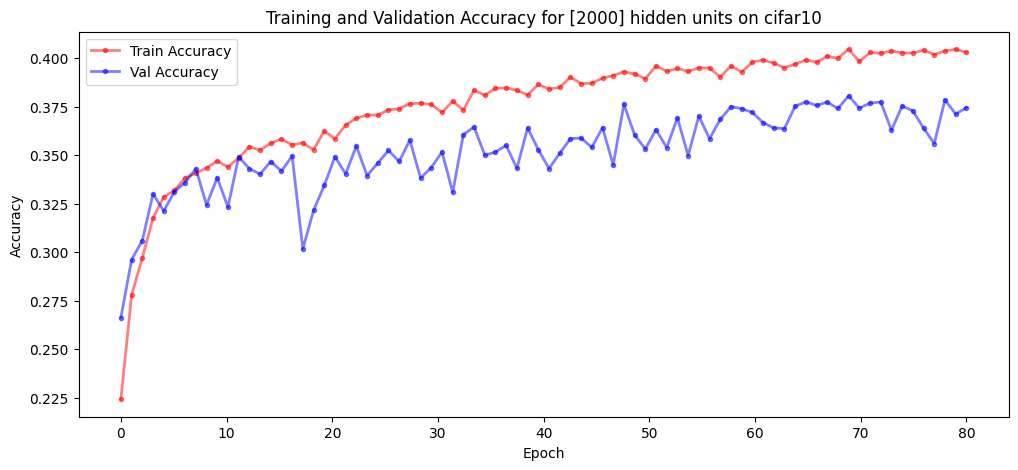

In [13]:

#### cifar10 ####
data_name = 'cifar10'
cfg = dataset_configs[data_name]
x_train, y_train, x_val, y_val, x_test, y_test = load_and_preprocess(cfg['data_name'], cfg['loader'], cfg['img_shape'], Nc, val_split, cfg['is_color'])
y_train = y_train.squeeze()
y_val = y_val.squeeze()

p = 2
delta = 0.1
k = 2
prec = 0.1
N_batch = 100
Nep  = 1000
lr = 4e-2


# parameters for supervised learning
out_features = 10
n_epochs_supervised = 80
batch_size_supervised = 100
correct_img_bzs = 100
n_hidden = 10
learning_rate = 0.01

# Load synapses bio
hidden_units_files = find_my_synapses(source_directory = './output_EI', data_name = data_name)

#Logging
with open("./output_EI/cifar10_acc_loss_training_data.txt", "w") as f:
    f.write("N_hidden\tVal_Acc\tTrain_Acc\tVal_loss\tTrain_loss\n")


# Train supervised last layer of size out_features x n_hid
for n_hidden in sorted(hidden_units_files.keys()):
    file_path = hidden_units_files[n_hidden]
    print(f"\n[INFO] Inizio supervised training con {n_hidden} hidden units, file: {file_path}")

    synapses = torch.load(file_path)
    synapses_list = [synapses]  

    train_loss_log, val_loss_log, train_acc_log, val_acc_log = train_bio_classifier(
        synapses_list=synapses_list,
        x_train = x_train,
        y_train = y_train,
        x_val = x_val, 
        y_val = y_val,
        correct_img_bzs=correct_img_bzs,
        data_name='mnist',
        layers_config=[n_hidden],  # aggiorna i layer con n_hidden corrente
        out_features=out_features,
        n_epochs=n_epochs_supervised,
        batch_size=batch_size_supervised,
        anti_hebbian_learning_strength=delta,
        lebesgue_norm=p,
        rank=k,
        learning_rate=lr,
        label=f'single-hidden-layer',
        output_dir='output_EI', 
        dataset_name = data_name
    )

    with open("./output_EI/cifar10_acc_loss_training_data.txt", "a") as f:
        f.write(f"{n_hidden}\t{np.mean(val_acc_log[-10:]):.4f}\t{np.mean(train_acc_log[-10:]):.4f}\t{np.mean(val_loss_log[-10:]):.4f}\t{np.mean(train_loss_log[-10:]):.4f}\n")
